In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ot
import ot.plot
import time
import numpy.linalg as la
import networkx as nx
import math
#from pointcloud_utils import vox_to_pointcloud
#import pointcloud_utils
from sklearn import manifold as man
# NOTE: RBFInterpolator needs scipy>=1.7.0
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator
#from scipy.interpolate import RBFInterpolator

In [12]:
# Read the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [98]:
# Functions for voxel reps and pointcloud reps
def vox_to_pointcloud(voxarray,grid,eps=0):
    # Convert a voxel representation ('voxarray') to a (weighted) point cloud representation
    # Assume that the input grid is in "ij meshgrid" format i.e. the grid has two layers, xx and yy, each size (nx)-by-(ny)
    # The voxel array will be unrolled via "column-major" order ("Fortran/Matlab" ordering)
    # Note that initially the number of voxels must equal the number of grid points - but
    # zero voxels will be removed from the representation (i.e. no points with weight zero allowed)
    # if the optional parameter eps is passed, voxels with value less or equal to eps will be dropped
    # The returned array consists of (x,y,w) tuples i.e. X = [x1,y1,w1;x2,y2,w2;...;xP,yP,wP] where P
    # is the number of nonzero points
    xx,yy = np.squeeze(np.split(grid,2))
    X = np.vstack((xx.ravel(),yy.ravel())).T
    nX  = X.shape[0] # Number of points = number of rows
    nvi = voxarray.shape[0] # Number of voxel rows
    nvj = voxarray.shape[1] # Number of voxel cols
    if nX != nvi*nvj: raise ValueError("Number of grid points must equal number of voxels!")
    X = np.concatenate((X,voxarray.T.reshape(nvi*nvj,1)),axis=1)
    return X[X[:,2]>eps,:]

def pointcloud_to_vox(array,grid):
    # Converts a pointcloud representation to a voxel representation
    # Assumes that the grid is in "ij meshgrid" format i.e. grid has two layers, xx and yy; each are size (nx+1)-by-(ny+1)
    # The grid points are assumed to define the corners of the voxels, so the
    # voxel rep will be a single nx-by-ny array with entries equal to the average pointcloud weights
    # V_ij = \mean_k W_k if (x_k,y_k) is in voxel ij
    xx,yy = np.squeeze(np.split(grid,2))

    points = array[:,0:2]
    values = array[:,2]
#   interp = NearestNDInterpolator(points,values)
    interp = LinearNDInterpolator(points,values,fill_value=0.0)
    X = interp(xx,yy).T
    #interp = RBFInterpolator(points,values,smoothing=0,kernel='linear')
    #X = np.reshape(interp(np.vstack((xx.ravel(),yy.ravel())).T),(xx.shape[0],xx.shape[1]))
    return X

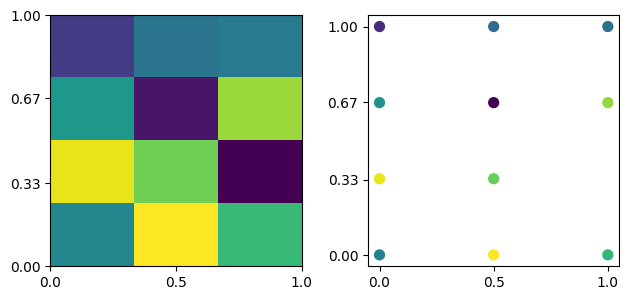

In [14]:
# Testing voxel-to-pointcloud conversion

# First, create voxel array
numx = 3
numy = 4

voxarray = np.random.rand(numy,numx)  # Note: number of rows = number of y points
# Set one of the elements to zero (to check zero weight handling)
voxarray[1,2] = 0

# Create a pointcloud grid for vox-to-PC conversion
nxg = numx
nyg = numy
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
# Convert voxel array to pointcloud
X = vox_to_pointcloud(voxarray,grid)
# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)

ax1.imshow(voxarray,origin='lower',extent=(0,1,0,1))
ax1.set_xticks(np.round(x,2))
ax1.set_yticks(np.round(y,2))
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)
ax2.set_xticks(np.round(x,2))
ax2.set_yticks(np.round(y,2))
fig1.tight_layout()

(0.0, 1.0)

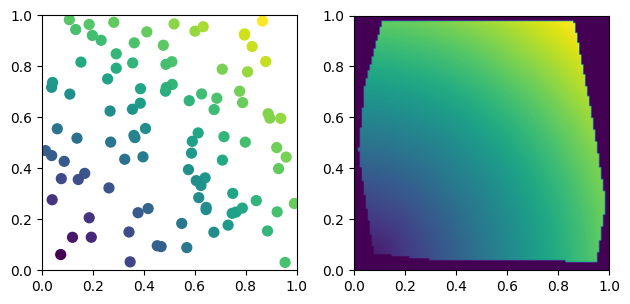

In [15]:
# Testing pointcloud-to-voxel conversion

# Generate a pointcloud by selecting random points
nPC = 100
points = np.random.rand(nPC,2)
values = np.hypot(points[:,0],points[:,1])
PCarray = np.hstack((points,values[:,np.newaxis]))
# Create a grid for pointcloud-to-voxel conversion
nxg = 129
nyg = 129
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
Y = pointcloud_to_vox(PCarray,grid)

fig2,(ax3,ax4) = plt.subplots(1,2)
fig2.tight_layout()
ax3.scatter(PCarray[:,0],PCarray[:,1],s=50,c=PCarray[:,2])
ax4.imshow(Y,origin='lower',extent=[0,1,0,1])
ax3.set_aspect(1)
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)

In [16]:
# Testing meshgrid, stack and split ops
nxg = 3
nyg = 4
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
xx2,yy2 = np.squeeze(np.split(grid,2))
#
display(xx)
display(yy)
display(grid)
display(xx2)
display(yy2)

array([[0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. ]])

array([[0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ]])

array([[[0.        , 0.        , 0.        , 0.        ],
        [0.5       , 0.5       , 0.5       , 0.5       ],
        [1.        , 1.        , 1.        , 1.        ]],

       [[0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ],
        [0.        , 0.33333333, 0.66666667, 1.        ]]])

array([[0. , 0. , 0. , 0. ],
       [0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. ]])

array([[0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ],
       [0.        , 0.33333333, 0.66666667, 1.        ]])

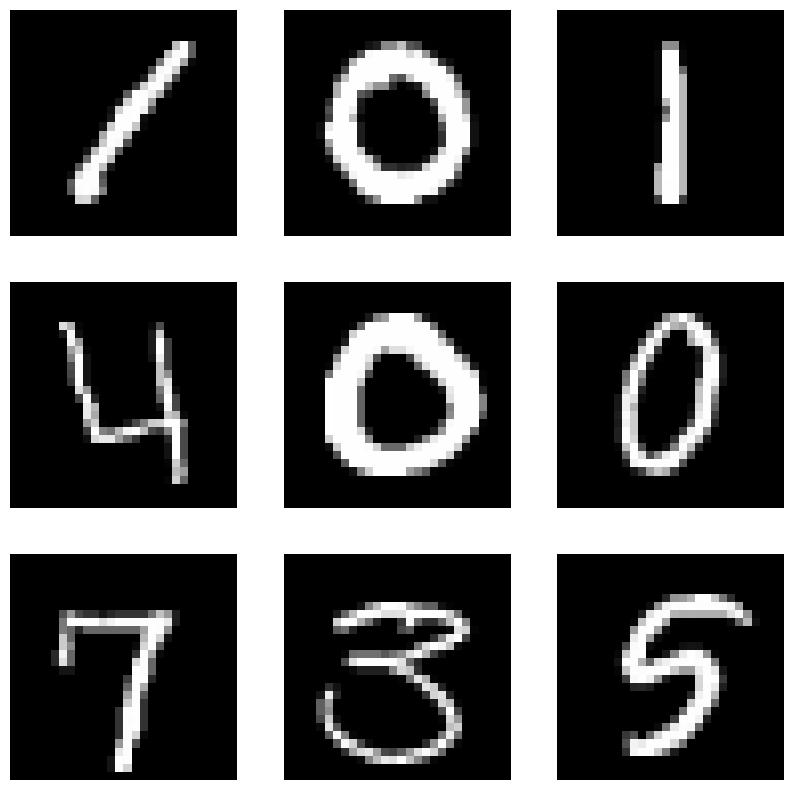

In [17]:
train_X = train_data.drop("label", axis=1).values
train_y = train_data['label'].values

test_X = test_data.values

img_rows, img_cols = 28, 28

train_X = train_X.reshape(train_X.shape[0], img_rows, img_cols)
test_X = test_X.reshape(test_X.shape[0], img_rows, img_cols)

# Create subplots
fig, plts = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        plts[i, j].imshow(train_X[idx], cmap=plt.get_cmap('gray'))
        plts[i, j].axis('off')  # Turn off axis
plt.show()


In [18]:
# Extract 0s
zeros = train_X[train_y==0]
zeros.shape

ones = train_X[train_y==1]

twos = train_X[train_y==2]

threes = train_X[train_y==3]

fours = train_X[train_y==4]

fives = train_X[train_y==5]
sixes = train_X[train_y==6]
sevens = train_X[train_y==7]
eights = train_X[train_y==8]
nines = train_X[train_y==9]

In [19]:
print(zeros.shape)

(4132, 28, 28)


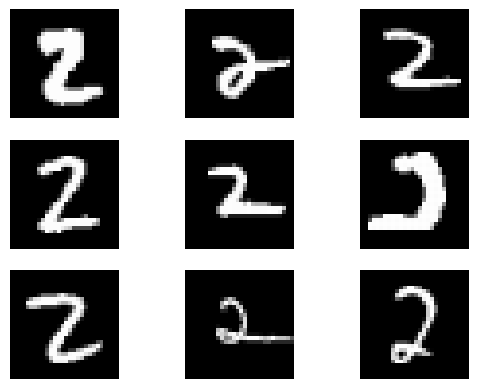

In [20]:
fig,plts = plt.subplots(3,3)
for i in range(3):
    for j in range(3):
        plts[i,j].imshow(twos[i + 3*j], cmap=plt.get_cmap('gray'))
        plts[i,j].axis('off')

grid shape (2, 28, 28)


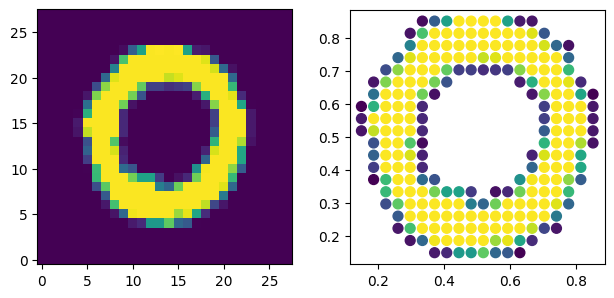

In [21]:
## Test creating pointclouds from MNIST zeros
nxg = 28
nyg = 28
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
print("grid shape",grid.shape)
# Convert voxel array to pointcloud
voxarray = zeros[0,:,:]
X = vox_to_pointcloud(voxarray,grid)

# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)
fig1.tight_layout()
ax1.imshow(voxarray,origin='lower')
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)
#print(X.shape)
#print(X)

grid shape (2, 28, 28)


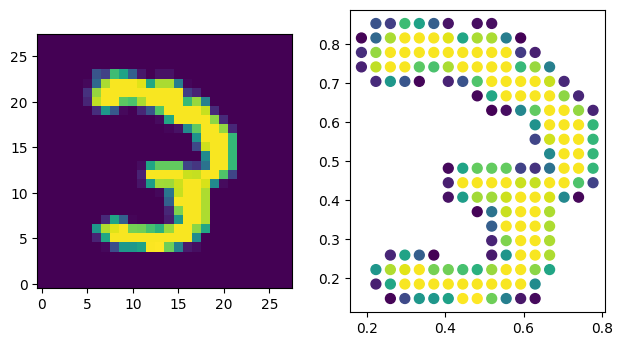

In [22]:
## Test creating pointclouds from MNIST threes
nxg = 28
nyg = 28
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
print("grid shape",grid.shape)
# Convert voxel array to pointcloud
voxarray = threes[1,:,:]
X = vox_to_pointcloud(voxarray,grid)

# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)
fig1.tight_layout()
ax1.imshow(voxarray,origin='lower')
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)
#print(X.shape)
#print(X)

grid shape (2, 28, 28)


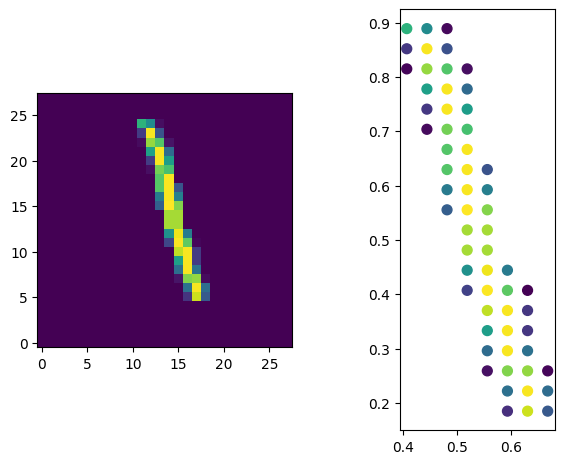

In [23]:
## Test creating pointclouds from MNIST ones
nxg = 28
nyg = 28
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))
print("grid shape",grid.shape)
# Convert voxel array to pointcloud
voxarray = ones[3,:,:]
X = vox_to_pointcloud(voxarray,grid)

# Plot voxel array and its pointcloud rep
fig1,(ax1,ax2) = plt.subplots(1,2)
fig1.tight_layout()
ax1.imshow(voxarray,origin='lower')
ax2.scatter(X[:,0],X[:,1],s=50,c=X[:,2])

ax2.set_aspect(1)
#print(X.shape)
#print(X)

### Wassmap embeddings 

In [47]:
def uniform_Wass_squared(U, V,Itermax=100000):
    # Assumes that U and V are pointclouds i.e. U = [x1,y1,w1;...;xp,yp,wp] etc
    Upts = np.ascontiguousarray(U[:,0:2])
    Vpts = np.ascontiguousarray(V[:,0:2])
    Uwts = np.ascontiguousarray(U[:,2])
    Vwts = np.ascontiguousarray(V[:,2])
    Uwts = Uwts/np.sum(Uwts)
    Vwts = Vwts/np.sum(Vwts)
    M = ot.dist(Upts, Vpts)  # Compute euclidean distance on the pointcloud points
    W = ot.emd2(Uwts,Vwts, M,numItermax=Itermax)
    return W

def Wasserstein_Matrix(image_list,squared=True):
    """
    The function compute the (squared if squared=True) Wasserstein Distance Matrix between N images
    image_list: python list of pointcloud representations
    """
    N = len(image_list) #number of images
    distance = np.zeros((N,N)) #initialize the distance matrix

    #cost = ot.dist(supp, supp) #should be a MXM array
    for i in range(N):
        for j in range(i+1,N):
            if squared==True:
                distance[i,j] = uniform_Wass_squared(image_list[i], image_list[j])
            else:
                distance[i,j] = uniform_Wass_squared(image_list[i], image_list[j])**.5
    distance += distance.T
    return distance

def Euclidean_Matrix(image_tensor,squared=True):
    """
    The function compute the (squared if squared=True) Euclidean Distance Matrix between N 2D images
    image_tensor: Should be a Mx2xN array, where M is the number of pixels.
    """
    N = image_tensor.shape[-1] #number of rows
    distance = np.zeros((N,N)) #initialize the distance matrix
    for i in range(N):
        for j in range(i+1,N):
            if squared==True:
                distance[i,j] = la.norm(image_tensor[:,:,i]-image_tensor[:,:,j])**2
            else:
                distance[i,j] = la.norm(image_tensor[:,:,i]-image_tensor[:,:,j])
    distance += distance.T
    return distance

def Geodesic_Matrix(image_tensor,eps,squared=True):
    """
    Computes the Geodesic distance matrix for a set of N images
    image_tensor is Mx2xN
    """
    Euc_distance = Euclidean_Matrix(image_tensor,squared=False)
    Adj_matrix = np.copy(Euc_distance)
    Adj_matrix[Adj_matrix<eps] = 0
    Euc_distance[Euc_distance<eps] = np.Inf
    G = nx.from_numpy_array(Adj_matrix)
    geo_matrix = shortest_path(Euc_distance, directed=False, return_predecessors=False)
    if(squared==True):
        geo_matrix = np.square(geo_matrix)
    return geo_matrix,G

def MDS(distance_matrix, num_components=2, squared=False):
    """
    Computes non-metric (classical) Multidimensional Scaling (MDS)
    Input should be an NxN distance matrix
    The Boolean squared indicates if the distance matrix passed to the function has already
    been squared entrywise (True) or not (False)
    """
    N = distance_matrix.shape[0]
    H = np.eye(N)-1/N*np.ones((N,N))
    if squared==False:
        B = -.5*H@(distance_matrix**2)@H
    else:
        B = -.5*H@distance_matrix@H
    U,S,VT = la.svd(B)
    embedding = U[:,:num_components]@np.diag(S[:num_components]**.5)
    return embedding

In [37]:
def generate_rectangle(side0, side1, initial_point=[0,0], samples=100):
    # Generates a rectangle in point cloud format
    x = np.linspace(initial_point[0], initial_point[0]+side0, num=samples)
    y = np.linspace(initial_point[1], initial_point[1]+side1, num=samples)
    return np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

def in_triangle(endpoint1,endpoint2,endpoint3,point):
    # Indicator function of a triangle
    # Returns 1 (True) if point is in the triangle, zero (False) else
    c1 = (endpoint2[0]-endpoint1[0])*(point[1]-endpoint1[1]) - (endpoint2[1]-endpoint1[1])*(point[0]-endpoint1[0])
    c2 = (endpoint3[0]-endpoint2[0])*(point[1]-endpoint2[1]) - (endpoint3[1]-endpoint2[1])*(point[0]-endpoint2[0])
    c3 = (endpoint1[0]-endpoint3[0])*(point[1]-endpoint3[1]) - (endpoint1[1]-endpoint3[1])*(point[0]-endpoint3[0])

    if (c1<0 and c2<0 and c3<0) or (c1>0 and c2>0 and c3>0):
        return True
    else:
        return False

def generate_triangle(endpoint1, endpoint2, endpoint3, samples=100):
    # Generates a triangle in point cloud format
    x = np.linspace(min(endpoint1[0],endpoint2[0],endpoint3[0]), max(endpoint1[0],endpoint2[0],endpoint3[0]), num=samples)
    y = np.linspace(min(endpoint1[1],endpoint2[1],endpoint3[1]), max(endpoint1[1],endpoint2[1],endpoint3[1]), num=samples)
    xy_0 = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    xy = []
    for point in xy_0:
        if in_triangle(endpoint1,endpoint2,endpoint3,point):
            xy.append(point)
    return np.array(xy)

def in_circle(center, radius, point):
    if (point[1]-center[1])**2+(point[0]-center[0])**2<=radius**2:
        return True
    else:
        return False

def generate_circle(center, radius, samples=100):
    x = np.linspace(center[0]-radius, center[0]+radius, num=samples)
    y = np.linspace(center[1]-radius, center[1]+radius, num=samples)
    xy_0 = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    xy = []
    for point in xy_0:
        if in_circle(center,radius,point):
            xy.append(point)
    return np.array(xy)

def generate_ellipse(center, axis_x, axis_y,samples = 100):
    circle = generate_circle([0,0],1,samples)
    ellipse = dilation(circle,[axis_x, axis_y])
    ellipse = translation(ellipse,center)
    return np.array(ellipse)

In [38]:
def rotation(object, radian_degree):
    A = [[math.cos(radian_degree), -math.sin(radian_degree)],[math.sin(radian_degree), math.cos(radian_degree)]]
    image = []
    for index,point in enumerate(object):
        image.append(np.matmul(A,point))
    return np.array(image)
def translation(object, translate_direction):
    object_array = np.array(object)
    direction_array = np.array(translate_direction)
    image = [x + direction_array for x in object_array]
    return np.array(image)

def dilation(object, parameter):
    A = [[parameter[0], 0],[0, parameter[1]]]
    image = []
    for index,point in enumerate(object):
        image.append(np.matmul(A,point))
    return np.array(image)

# def diffeo(object, diff_fun):
#     object_array = np.array(object)
#     image = [diff_fun(x) for x in object_array]
#     return np.array(image)

def diffeo(object, a,b):
    object_array = np.array(object)
    image = np.array([1/(a*b*np.exp(a*object_array[:,0])*np.exp(b*object_array[:,1]))*np.exp(a*object_array[:,0]), 1/(a*b*np.exp(a*object_array[:,0])*np.exp(b*object_array[:,1]))*np.exp(b*object_array[:,1])]).T
#    image = np.array([np.exp(a*object_array[:,0]), np.reciprocal((1+b*object_array[:,1])**2)]).T
    print(image.shape)
    return np.array(image)

Text(0.5, 0.98, 'Image Sample (Voxels)')

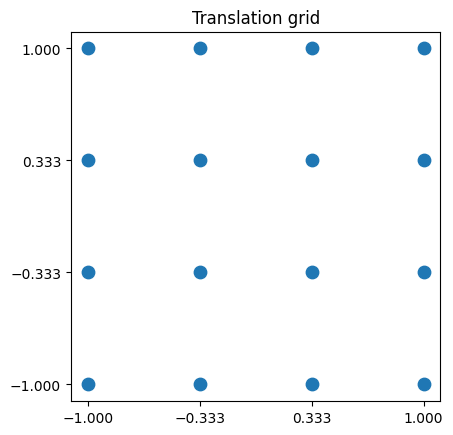

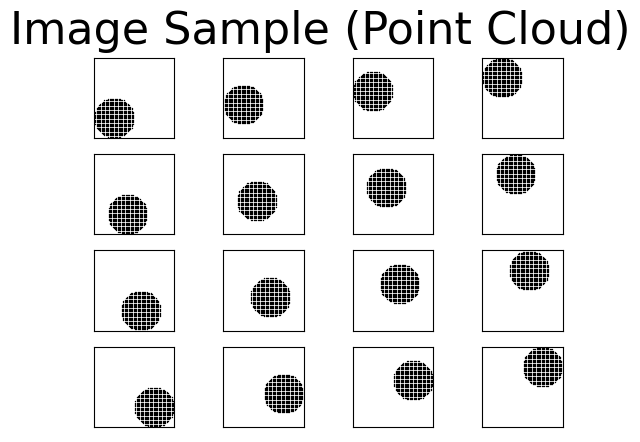

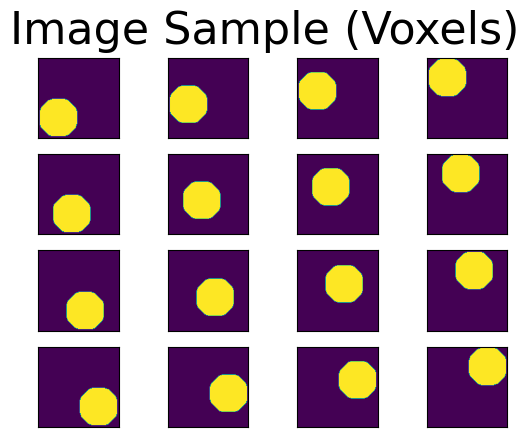

In [39]:
##Circle translate test 1:OVERLAPPING IMAGES::Image generation and setup
# NOTE: In this test, the translation grid is such that the resulting synthetic
# images will overlap.  Thus, Isomap is at least well-defined (i.e. there are meaningful geodesics)

# Generate circle
num_samplepoints = 32
circ = generate_circle([0,0],1,samples=num_samplepoints)

# Generate translation set
num_translates = 4
num_samp = num_translates**2
x = np.linspace(-1,1,num=num_translates)
y = np.linspace(-1,1,num=num_translates)
xx,yy = np.meshgrid(x,y) #num_translates x num_translates matrices; each xx,yy entry is a translation vector
xx = np.reshape(xx,(num_translates**2,1))
yy = np.reshape(yy,(num_translates**2,1))
translates = np.zeros((num_translates**2,2))
for i in range(len(xx)):
    translates[i,0] = xx[i]
    translates[i,1] = yy[i]

# Plot the translation set
fig1,ax1 = plt.subplots()
ax1.scatter(translates[:,0],translates[:,1],s=80)
ax1.set_aspect('equal')
ax1.set_title('Translation grid')
ax1.set_xticks(x)
ax1.set_yticks(y)

#plt.savefig('/content/drive/My Drive/Colab Notebooks/figures/trans1_paramset.pdf',bbox_inches='tight')

# Generate translation images and image tensor
trans_images = []
for i in range(num_translates**2):
    img = np.concatenate((translation(circ,[translates[i,0],translates[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
    trans_images.append(img)

# Generate voxel images (for ISOmap)
nvox = 128
nxg = nvox
nyg = nvox

xg = np.linspace(-2,2,nxg)
yg = np.linspace(-2,2,nyg)
xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
grid = np.stack((xxg,yyg))
trans_images_vox = np.zeros((nvox,nvox,num_translates**2))
for i in range(num_translates**2):
    pc = trans_images[i]
    trans_images_vox[:,:,i] = pointcloud_to_vox(pc,grid)

fig2,transaxes = plt.subplots(num_translates,num_translates)

xtick = np.linspace(-2,2,5)
ytick = xtick

idx = 0
for i in range(num_translates):
    for j in range(num_translates):
        idx = i + num_translates*j
        xxplt = trans_images[idx][:,0]
        yyplt = trans_images[idx][:,1]
        transaxes[i,j].scatter(xxplt,yyplt,s=1,linewidths=0,c='#000000')
        transaxes[i,j].set_xlim([-2,2])
        transaxes[i,j].set_ylim([-2,2])
        transaxes[i,j].set_aspect('equal')
        transaxes[i,j].set_xticks([])
        transaxes[i,j].set_yticks([])
#fig2.tight_layout()
fig2.suptitle('Image Sample (Point Cloud)',fontsize=32)
#plt.savefig('/content/drive/My Drive/Colab Notebooks/figures/trans1_images_PC.pdf',bbox_inches='tight')


# Voxel image figure
fig3,transaxes_vox = plt.subplots(num_translates,num_translates)
idx = 0
for i in range(num_translates):
    for j in range(num_translates):
        idx = i + num_translates*j
        transaxes_vox[i,j].imshow(trans_images_vox[:,:,idx],origin='lower',extent=(-1.5,1.5,-1.5,1.5))
        transaxes_vox[i,j].set_xticks([])
        transaxes_vox[i,j].set_yticks([])
fig3.suptitle('Image Sample (Voxels)',fontsize=32)
#fig3.tight_layout()
#plt.savefig('/content/drive/My Drive/Colab Notebooks/figures/trans1_images_vox.pdf',bbox_inches='tight')

### Wasserstein Matrix

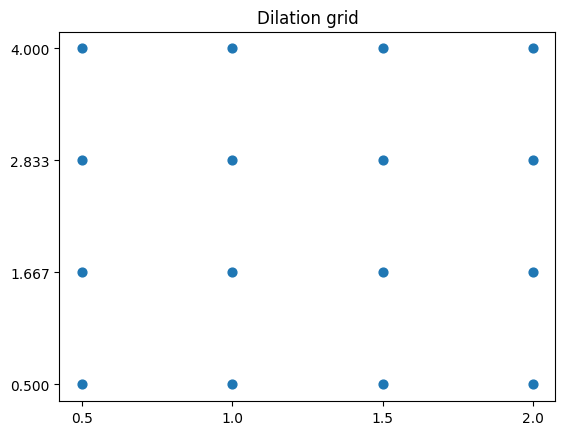

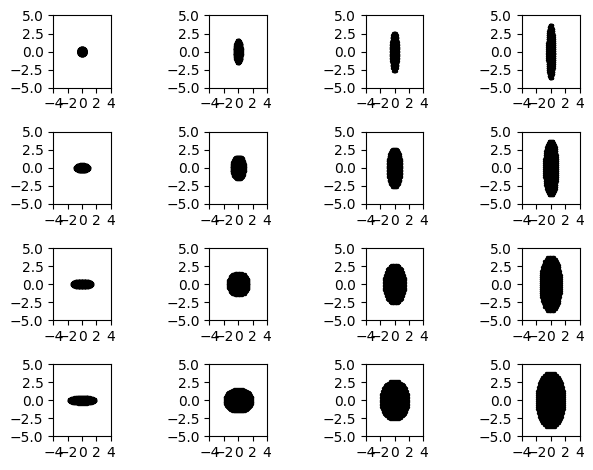

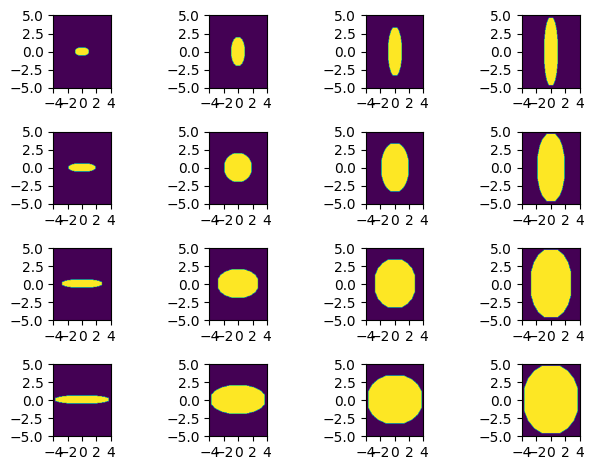

In [48]:
## Circle dilation test

# Generate circle
num_samplepoints = 30
radius = 1#0.1
circ = generate_circle([0,0],radius,samples=num_samplepoints)

# Generate dilation set
num_dilates = 4
x = np.linspace(.5,2,num=num_dilates)
y = np.linspace(.5,4,num=num_dilates)
xx,yy = np.meshgrid(x,y) #num_dilates x num_dilates matrices; each xx,yy entry is a dilation vector
xx = np.reshape(xx,(num_dilates**2,1))
yy = np.reshape(yy,(num_dilates**2,1))
dilates = np.zeros((num_dilates**2,2))
for i in range(len(xx)):
    dilates[i,0] = xx[i]
    dilates[i,1] = yy[i]

# Plot the dillation set
fig1,ax1 = plt.subplots()
ax1.scatter(dilates[:,0],dilates[:,1],s=40)
#ax1.set_aspect('equal')
ax1.set_title('Dilation grid')
ax1.set_xticks(x)
ax1.set_yticks(y)
#plt.savefig('trans1_param_set.pdf')

# Generate dilation images and image tensor
dil_images = []
for i in range(num_dilates**2):
    img = np.concatenate((dilation(circ,[dilates[i,0],dilates[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
    dil_images.append(img)

# Generate voxel images (for ISOmap)
nvox = 128
nxg = nvox
nyg = nvox

xg = np.linspace(-2,2,nxg)
yg = np.linspace(-4,4,nyg)
xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
grid = np.stack((xxg,yyg))
dil_images_vox = np.zeros((nvox,nvox,num_dilates**2))
for i in range(num_dilates**2):
    pc = dil_images[i]
    dil_images_vox[:,:,i] = pointcloud_to_vox(pc,grid)

fig2,dilaxes = plt.subplots(num_dilates,num_dilates)
fig2.tight_layout()

xticks = np.linspace(-4,4,5)
yticks = np.linspace(-5,5,5)

idx = 0
for i in range(num_dilates):
    for j in range(num_dilates):
        idx = i + num_dilates*j
        xxplt = dil_images[idx][:,0]
        yyplt = dil_images[idx][:,1]
        dilaxes[i,j].scatter(xxplt,yyplt,s=2,c='#000000')
        dilaxes[i,j].set_xlim([-4,4])
        dilaxes[i,j].set_ylim([-5,5])
        dilaxes[i,j].set_aspect('equal')
        dilaxes[i,j].set_xticks(xticks)
        dilaxes[i,j].set_yticks(yticks)

#plt.savefig('trans1_iamges.pdf')

fig3,dilaxes_vox = plt.subplots(num_dilates,num_dilates)
fig3.tight_layout()

idx = 0
for i in range(num_dilates):
    for j in range(num_dilates):
        idx = i + num_dilates*j
        dilaxes_vox[i,j].imshow(dil_images_vox[:,:,idx],origin='lower',extent = (-4,4,-5,5))
        dilaxes_vox[i,j].set_xticks(xticks)
        dilaxes_vox[i,j].set_yticks(yticks)

Computed Wasserstein distance matrix (N = 16) in 7.5168 seconds


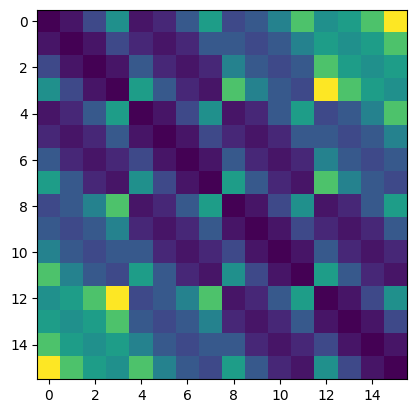

In [40]:
tic = time.perf_counter()
Wass_distance_trans = Wasserstein_Matrix(trans_images,squared=True)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance_trans)

### Wassmap MDS

Text(0.5, 1.0, 'Wassmap Embedding')

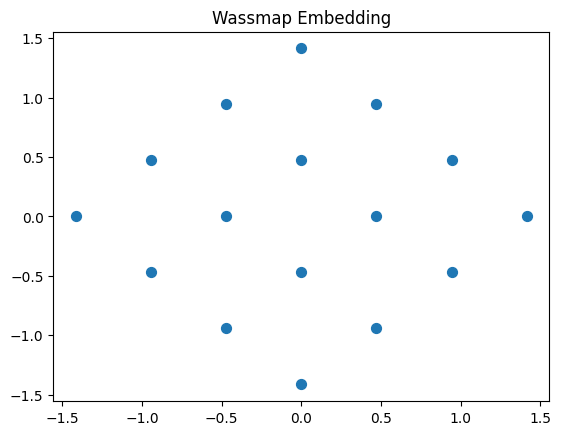

In [42]:
WassEmbedding_trans = MDS(Wass_distance_trans,squared=True)
fig, ax1 = plt.subplots()
scatter_x = WassEmbedding_trans[:,0]
scatter_y = WassEmbedding_trans[:,1]
ax1.scatter(scatter_x,scatter_y,s=50)
#ax1.set_xlim([-8,9.5])
#ax1.set_ylim([-8,9.5])
ax1.set_title('Wassmap Embedding')

### Euclidean Matrix

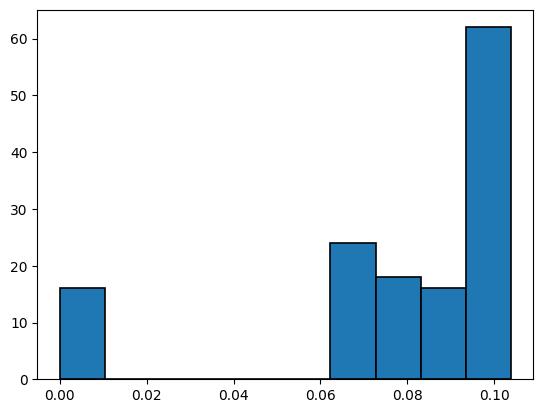

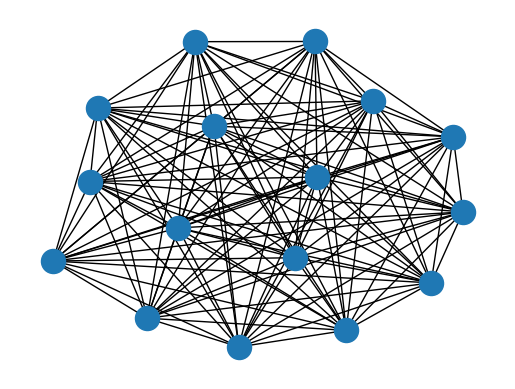

In [43]:
euc_matrix = Euclidean_Matrix(trans_images_vox,squared=False)
#print(euc_matrix)
fig,ax1 = plt.subplots()
plt.hist(euc_matrix[np.triu_indices(num_translates**2)],edgecolor='black', linewidth=1.2)
eps = .02
# NOTE: if eps is too large, the graph will be disconnected and the distance matrix will have infs.
# GENERAL STRATEGY: Pick eps to be the largest value such that the graph remains connected
# You can use the distance histogram to pick this manually
geo_distance,geo_graph = Geodesic_Matrix(trans_images_vox,eps,squared = True)
# print('Graph weight matrix:')
# print(nx.adjacency_matrix(geo_graph).todense())
# print('Geodesic Distance Matrix:')
# print(geo_distance)
# print([n for n in geo_graph.neighbors(1)])
fig, ax2 = plt.subplots()
#nx.draw(geo_graph,ax=ax2,pos=nx.kamada_kawai_layout(geo_graph))
nx.draw(geo_graph,ax=ax2,pos=nx.spring_layout(geo_graph))

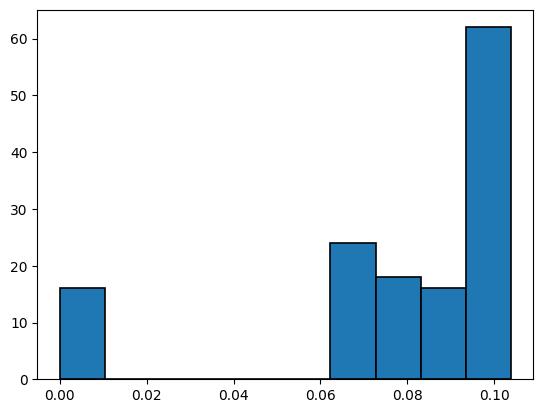

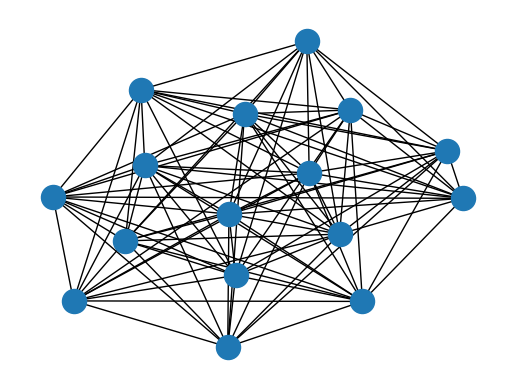

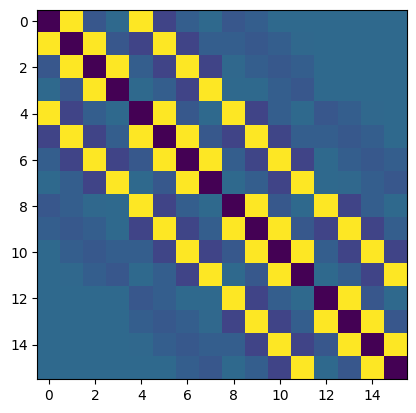

In [57]:
## Circle translation test :: compute Euclidean distance matrix and select threshold
# Use the histogram to select the threshold.  Note that we want the un-squared matrix to select the threshold!
euc_matrix_trans = Euclidean_Matrix(trans_images_vox,squared=False)
#print(euc_matrix)
fig,ax1 = plt.subplots()
plt.hist(euc_matrix_trans[np.triu_indices(num_translates**2)],edgecolor='black', linewidth=1.2)
eps = .07
#eps = .025
# NOTE: if eps is too large, the graph will be disconnected and the distance matrix will have infs.
# GENERAL STRATEGY: Pick eps to be the largest value such that the graph remains connected
# You can use the distance histogram to pick this manually
geo_distance_trans,geo_graph_trans = Geodesic_Matrix(trans_images_vox,eps,squared = True)
# print('Graph weight matrix:')
# print(nx.adjacency_matrix(geo_graph).todense())
# print('Geodesic Distance Matrix:')
# print(geo_distance)
# print([n for n in geo_graph.neighbors(1)])
fig, ax2 = plt.subplots()
#nx.draw(geo_graph,ax=ax2,pos=nx.kamada_kawai_layout(geo_graph))
nx.draw(geo_graph_trans,ax=ax2,pos=nx.spring_layout(geo_graph_trans))

fig,ax3 = plt.subplots()
ax3.imshow(geo_distance_trans)

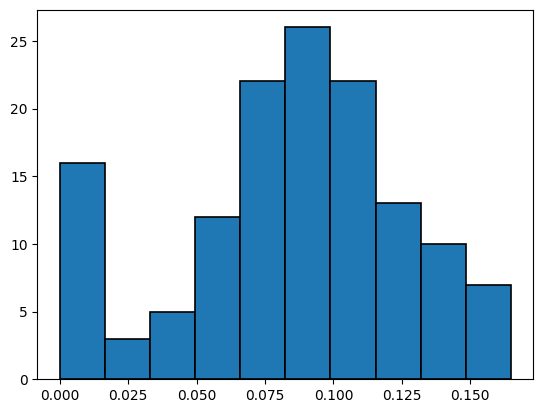

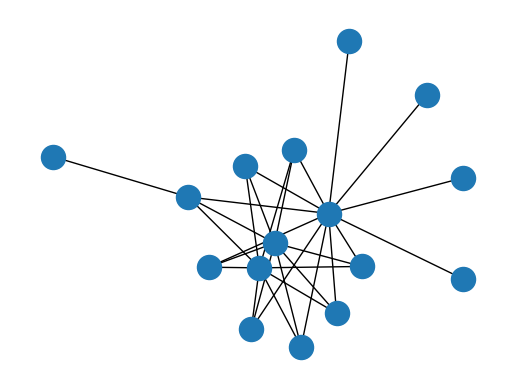

In [49]:
### Circle dilation test :: compute Euclidean distance matrix and select threshold
# Use the histogram to select the threshold.  Note that we want the un-squared matrix to select the threshold!
euc_matrix = Euclidean_Matrix(dil_images_vox,squared=False)
#print(euc_matrix)
fig,ax1 = plt.subplots()
plt.hist(euc_matrix[np.triu_indices(num_dilates**2)],edgecolor='black', linewidth=1.2)
eps = .118
# NOTE: if eps is too large, the graph will be disconnected and the distance matrix will have infs.
# GENERAL STRATEGY: Pick eps to be the largest value such that the graph remains connected
# You can use the distance histogram to pick this manually
geo_distance,geo_graph = Geodesic_Matrix(dil_images_vox,eps,squared = True)
# print('Graph weight matrix:')
# print(nx.adjacency_matrix(geo_graph).todense())


# print('Geodesic Distance Matrix:')
# print(geo_distance)
# print([n for n in geo_graph.neighbors(1)])
fig, ax2 = plt.subplots()
#nx.draw(geo_graph,ax=ax2,pos=nx.kamada_kawai_layout(geo_graph))
nx.draw(geo_graph,ax=ax2,pos=nx.spring_layout(geo_graph))

## MDS

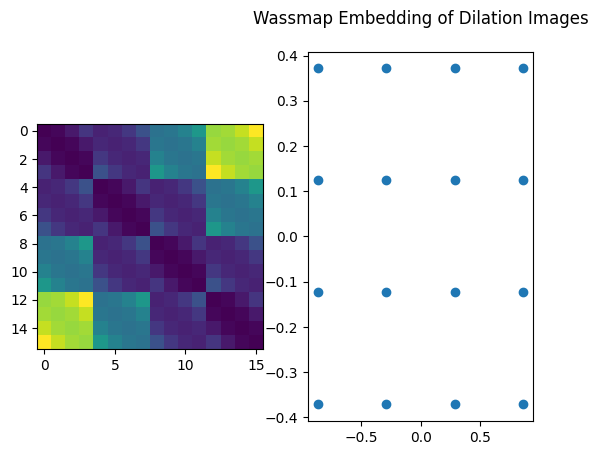

In [54]:
# Compute Wasserstein square distance matrix
squared = True
Wass_distance = Wasserstein_Matrix(dil_images,squared=squared)

# Compute and display Wassmap embedding
#WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
WassEmbedding = MDS(Wass_distance,squared=squared)
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(Wass_distance)
ax2.set_title("Wassmap Embedding of Dilation Images",pad=20)
ax2.scatter(WassEmbedding[:,0],WassEmbedding[:,1])
#plt.savefig('figures/DilationWassmapEmbedding.pdf')
plt.show()

### Iso map

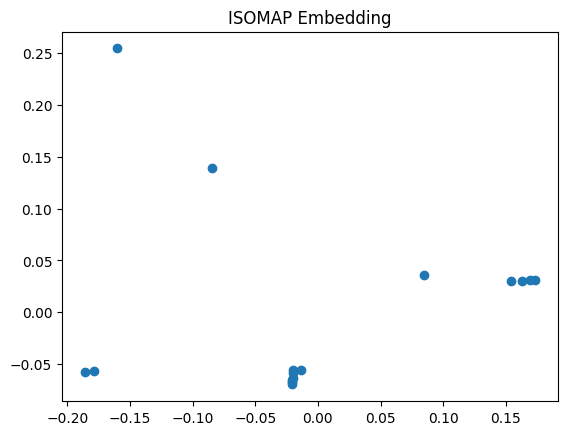

In [60]:
EucEmbedding = MDS(geo_distance,squared=True)
fig, ax3 = plt.subplots()
ax3.scatter(EucEmbedding[:,0], EucEmbedding[:,1])
ax3.set_title("ISOMAP Embedding")
plt.show()

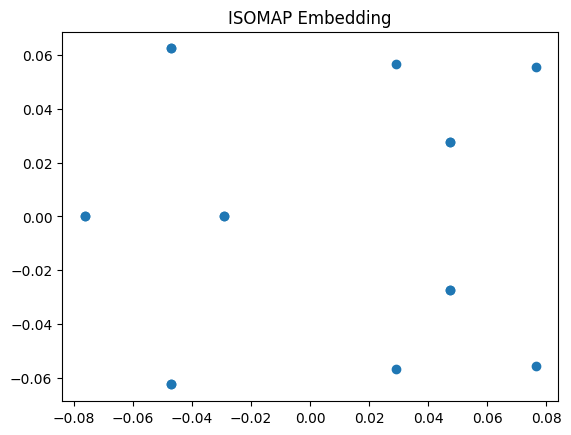

In [62]:
# Compute the geodesic distance matrix
EucEmbedding_trans = MDS(geo_distance_trans,squared=True)
#EucEmbedding = MDS(euc_matrix,squared=True)
fig, ax3 = plt.subplots()
ax3.scatter(EucEmbedding_trans[:,0], EucEmbedding_trans[:,1])
ax3.set_title("ISOMAP Embedding")
plt.show()


(16, 2)


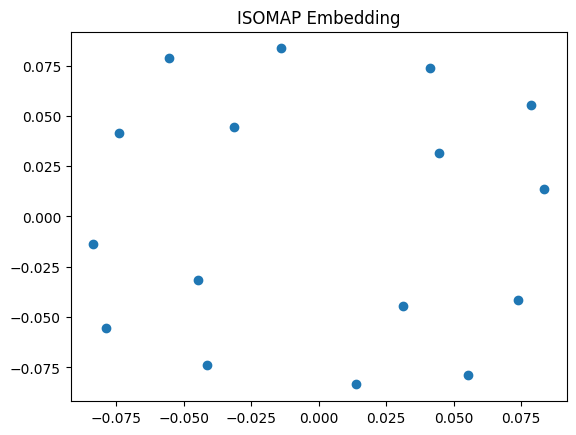

In [64]:
temp = np.reshape(trans_images_vox.T,[trans_images_vox.shape[-1],trans_images_vox.shape[0]**2])
trans_embedded_isomap = man.Isomap(n_neighbors=7,n_components=2,metric='euclidean').fit_transform(temp)
print(trans_embedded_isomap.shape)
fig, ax = plt.subplots()
scatter_x = trans_embedded_isomap[:,0]
scatter_y = trans_embedded_isomap[:,1]
# for g in np.unique(small_mnist_labels):
#     i = np.where(small_mnist_labels == g)
ax.scatter(scatter_x, scatter_y)
ax.set_title("ISOMAP Embedding")
#plt.savefig('/content/drive/My Drive/Colab Notebooks/figures/TranslationISOMAPEmbedding.pdf',bbox_inches='tight')
#ax.legend()
plt.show()

In [65]:
print(dil_images_vox.shape)
print(128*128)
temp = np.reshape(dil_images_vox,[dil_images_vox.shape[-1],dil_images_vox.shape[0]**2])
print(temp.shape)

(128, 128, 16)
16384
(16, 16384)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(16, 2)


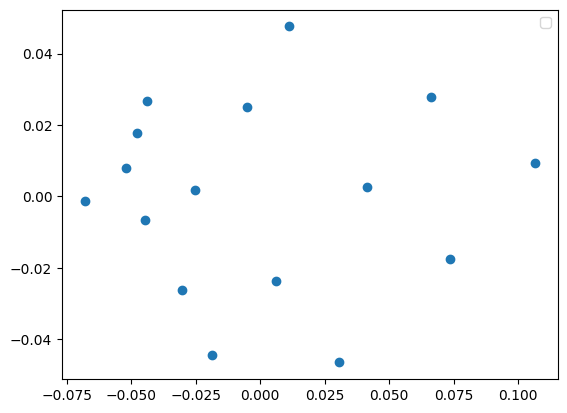

In [56]:
temp = np.reshape(dil_images_vox.T,[dil_images_vox.shape[-1],dil_images_vox.shape[0]**2])
dil_embedded_isomap = man.Isomap(n_neighbors=14,n_components=2,metric='euclidean',).fit_transform(temp)
print(dil_embedded_isomap.shape)
fig, ax = plt.subplots()
scatter_x = dil_embedded_isomap[:,0]
scatter_y = dil_embedded_isomap[:,1]
# for g in np.unique(small_mnist_labels):
#     i = np.where(small_mnist_labels == g)
ax.scatter(scatter_x, scatter_y)
ax.legend()
plt.show()

Computed Wasserstein distance matrix (N = 16) in 7.4929 seconds


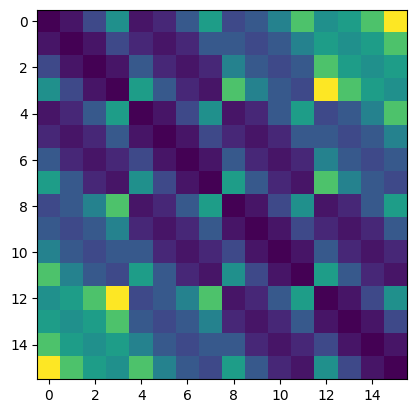

In [66]:
tic = time.perf_counter()
Wass_distance = Wasserstein_Matrix(trans_images,squared=True)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance)
plt.show()

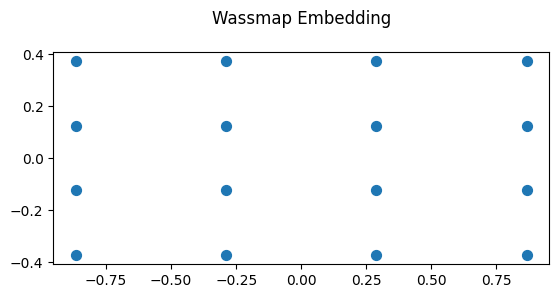

In [68]:
fig, ax1 = plt.subplots()
scatter_x = WassEmbedding[:,0]
scatter_y = WassEmbedding[:,1]
ax1.scatter(scatter_x,scatter_y,s=50)
ax1.set_aspect("equal")
# ax1.set_xlim([-8,9.5])
# ax1.set_ylim([-8,9.5])
ax1.set_title('Wassmap Embedding',pad=20)
#plt.savefig('/content/drive/My Drive/Colab Notebooks/figures/TranslationNonconvexWassmapEmbeddingOverlap.pdf',bbox_inches='tight')
#plt.savefig('figures/TranslationNonconvexWassmapEmbedding.pdf')
plt.show()

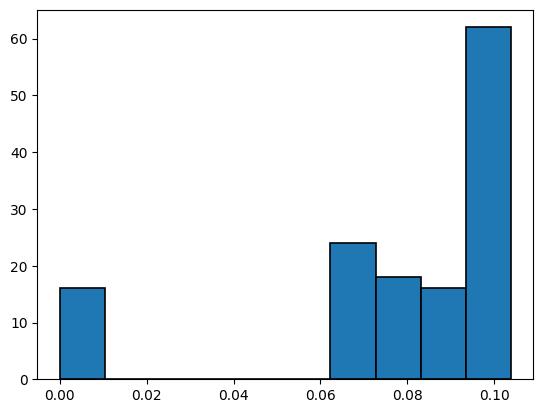

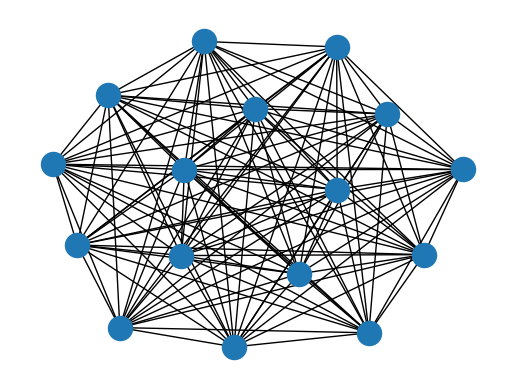

In [74]:
## Circle translation test :: compute Euclidean distance matrix and select threshold
# Use the histogram to select the threshold.  Note that we want the un-squared matrix to select the threshold!
euc_matrix = Euclidean_Matrix(trans_images_vox,squared=False)
#print(euc_matrix)
fig,ax1 = plt.subplots()
plt.hist(euc_matrix[np.triu_indices(num_translates**2)],edgecolor='black', linewidth=1.2)
eps = .005
# NOTE: if eps is too large, the graph will be disconnected and the distance matrix will have infs.
geo_distance,geo_graph = Geodesic_Matrix(trans_images_vox,eps,squared = True)
# print('Graph weight matrix:')
# print(nx.adjacency_matrix(geo_graph).todense())
# print('Geodesic Distance Matrix:')
# print(geo_distance)
# print([n for n in geo_graph.neighbors(1)])
fig, ax2 = plt.subplots()
#nx.draw(geo_graph,ax=ax2,pos=nx.kamada_kawai_layout(geo_graph))
nx.draw(geo_graph,ax=ax2,pos=nx.spring_layout(geo_graph))

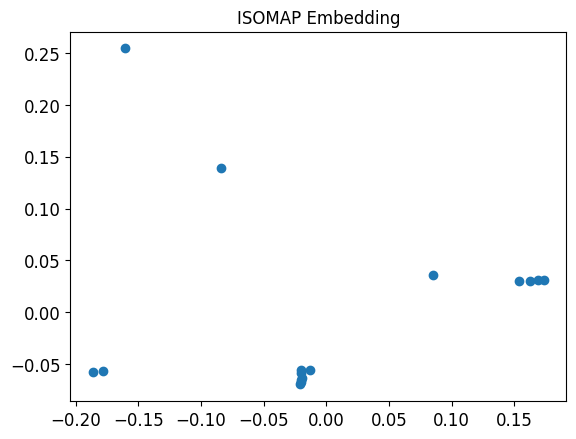

In [70]:
EucEmbedding = MDS(geo_distance,squared=True)
fig, ax3 = plt.subplots()
ax3.scatter(EucEmbedding[:,0], EucEmbedding[:,1])
ax3.set_title("ISOMAP Embedding")
ax3.tick_params(labelsize=12)
#plt.savefig('/content/drive/My Drive/Colab Notebooks/figures/TranslationNonconvexISOMAPEmbeddingOverlap.pdf',bbox_inches='tight')
plt.show()

(16, 2)


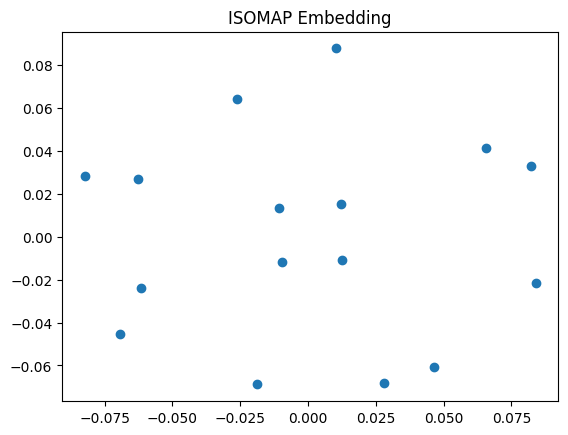

In [73]:
temp = np.reshape(trans_images_vox.T,[trans_images_vox.shape[-1],trans_images_vox.shape[0]**2])
trans_embedded_isomap = man.Isomap(n_neighbors=10,n_components=2,metric='euclidean',).fit_transform(temp)#Have to fix n_neighbors
print(trans_embedded_isomap.shape)
fig, ax = plt.subplots()
scatter_x = trans_embedded_isomap[:,0]
scatter_y = trans_embedded_isomap[:,1]
# for g in np.unique(small_mnist_labels):
#     i = np.where(small_mnist_labels == g)
ax.scatter(scatter_x, scatter_y)
ax.set_title("ISOMAP Embedding")
#plt.savefig('/content/drive/My Drive/Colab Notebooks/figures/TranslationNonconvexISOMAPEmbeddingOverlap.pdf',bbox_inches='tight')
plt.show()

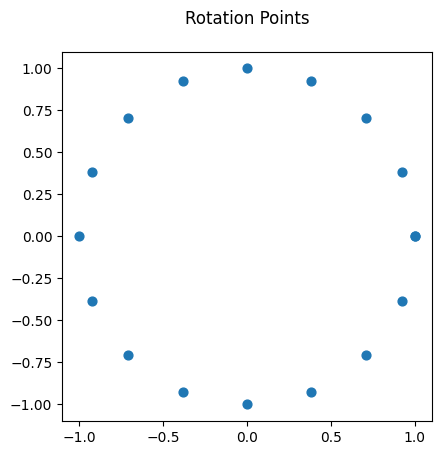

In [79]:
##Ellipse rotation test::Image generation and setup

# Generate ellipse
num_samplepoints = 32
ellipse = generate_ellipse([0,0], 1, .5, samples = num_samplepoints)

# Generate translation set
num_rotations = 17
#num_samp = num_translates**2
theta = np.linspace(0,2*np.pi,num=num_rotations)
x = np.cos(theta)
y = np.sin(theta)
# np.random.shuffle(x) # Shuffle to make sure the order of the images doesn't matter
# np.random.shuffle(y)
#print(x)
#print(y)
# xx,yy = np.meshgrid(x,y) #num_translates x num_translates matrices; each xx,yy entry is a translation vector
# xx = np.reshape(xx,(num_rotations,1))
# yy = np.reshape(yy,(num_rotations,1))
rotates = np.zeros((num_rotations,2))
for i in range(len(x)):
    rotates[i,0] = x[i]
    rotates[i,1] = y[i]


# Plot the rotation set
fig1,ax1 = plt.subplots()
ax1.scatter(rotates[:,0],rotates[:,1],s=40)
ax1.set_aspect('equal')
ax1.set_title('Rotation Points',pad=20)
#plt.savefig('/content/drive/My Drive/Colab Notebooks/figures/RotationAngles.pdf',bbox_inches='tight')

#plt.savefig('figures/RotationAngles.pdf')
plt.show()
# ax1.set_xticks(x)
# ax1.set_yticks(y)
#plt.savefig('trans1_param_set.pdf')

# Generate translation images and image tensor
# rot_images = np.zeros((ellipse.shape[0],ellipse.shape[1],num_rotations))
# for i in range(num_rotations):
#     rot_images[:,:,i] = rotation(ellipse,theta[i])

rot_images = []
for i in range(rotates.shape[0]):
    img = np.concatenate((rotation(ellipse,theta[i]),np.ones((ellipse.shape[0],1))/ellipse.shape[0]),axis=1)
    rot_images.append(img)


# fig2,ax2 = plt.subplots(1,int(num_rotations/2))
# fig2.tight_layout()
# for i in range(int(num_rotations/2)):
#     #for j in range(int(num_rotations/2)):
# #         xxplt = rot_images[:,0,i+num_rotations*j]
# #         yyplt = rot_images[:,1,i+num_rotations*j]
#         xxplt = rot_images[:,0,i]
#         yyplt = rot_images[:,1,i]
#         ax2[i].scatter(xxplt,yyplt,s=2,c='#000000')
#         ax2[i].set_aspect('equal')
#         if max(xxplt)<.6:
#             ax2[i].set_xticks([round(2*max(xxplt))/2])
#         else:
#             ax2[i].set_xticks([round(2*min(xxplt))/2,round(2*max(xxplt))/2])
#         if max(yyplt)<.6:
#             ax2[i].set_yticks([round(2*max(yyplt))/2])
#         else:
#             ax2[i].set_yticks([round(2*min(yyplt))/2,round(2*max(yyplt))/2])
# fig2.suptitle("Rotation Images",fontsize = 24,y=.65)
#plt.savefig('figures/RotationImages.pdf')


# Generate voxel images (for ISOmap)
nvox = 128
nxg = nvox
nyg = nvox

xg = np.linspace(-6,6,nxg)
yg = np.linspace(-6,6,nyg)
xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
grid = np.stack((xxg,yyg))
rot_images_vox = np.zeros((nvox,nvox,len(rot_images)))
for i in range(len(rot_images)):
    pc = rot_images[i]
    rot_images_vox[:,:,i] = pointcloud_to_vox(pc,grid)
#ax2 = ax2.reshape(ax2,(4,4))
#print(trans_images)
# fig2,ax2 = plt.subplots(int(num_rotations/2),int(num_rotations/2))
# for i in range(int(num_rotations/2)):
#     for j in range(int(num_rotations/2)):
# #         xxplt = rot_images[:,0,i+num_rotations*j]
# #         yyplt = rot_images[:,1,i+num_rotations*j]
#         xxplt = rot_images[:,0,i]
#         yyplt = rot_images[:,1,i]
#         ax2[i,j].scatter(xxplt,yyplt,s=2,c='#000000')
#         ax2[i,j].set_aspect('equal')
# ax2.set_xlim([-6,6])
# ax2.set_ylim([-6,6])
#ax2.set_title('Image Sample')
# ax2.set_xticks(x)
# ax2.set_yticks(y)
# plt.savefig('trans1_iamges.pdf')

# fig2,dilate_axs = plt.subplots(num_dilates,num_dilates)
# fig2.tight_layout(pad = .5)
# fig2.suptitle("Dilation images",fontsize=18,y=1.03)
# for i in range(num_dilates):
#     for j in range(num_dilates):
#         idx = i+num_dilates*j
#         xxplt = dil_images[:,0,idx]
#         yyplt = dil_images[:,1,idx]
#         dilate_axs[i,j].scatter(xxplt,yyplt,s=2,c='#000000')
#         dilate_axs[i,j].set_aspect('equal')
#         if max(xxplt)<.5 and max(yyplt)>2:
#             dilate_axs[i,j].set_xticks([round(2*max(xxplt))/2])
#         else:
#             dilate_axs[i,j].set_xticks([round(2*min(xxplt))/2,round(2*max(xxplt))/2])
# #         dilate_axs[i,j].set_xlim([-radius*dilates[idx,0],radius*dilates[idx,0]])
# #         dilate_axs[i,j].set_ylim([-radius*dilates[idx,1],radius*dilates[idx,1]])
plt.show()

Computed Wasserstein distance matrix (N = 16) in 7.0155 seconds


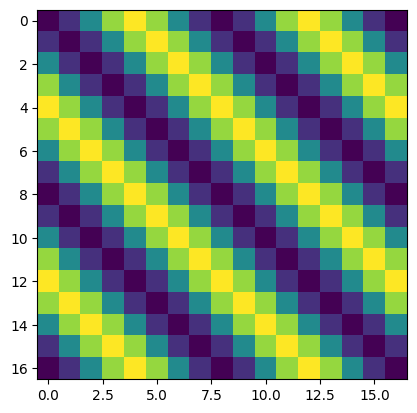

In [80]:
## Ellipse rotation test :: Compute Wasserstein square distance matrix
tic = time.perf_counter()
Wass_distance = Wasserstein_Matrix(rot_images,squared=True)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance)
plt.show()

[[-1.64284110e-01  1.04372639e-17]
 [-1.13352782e-01 -1.23664244e-01]
 [ 9.81402952e-03 -1.74887651e-01]
 [ 1.33956123e-01 -1.23664244e-01]
 [ 1.85591424e-01  4.70730557e-18]
 [ 1.33956123e-01  1.23664244e-01]
 [ 9.81402952e-03  1.74887651e-01]
 [-1.13352782e-01  1.23664244e-01]
 [-1.64284110e-01  1.09547495e-17]
 [-1.13352782e-01 -1.23664244e-01]
 [ 9.81402952e-03 -1.74887651e-01]
 [ 1.33956123e-01 -1.23664244e-01]
 [ 1.85591424e-01 -1.32587585e-16]
 [ 1.33956123e-01  1.23664244e-01]
 [ 9.81402952e-03  1.74887651e-01]
 [-1.13352782e-01  1.23664244e-01]
 [-1.64284110e-01  6.57632740e-19]]


Text(0.5, 1.0, 'Wassmap Embedding')

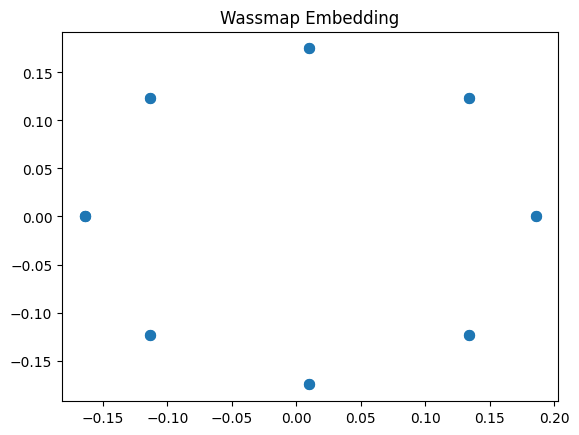

In [87]:
# MDS on Wass squared matrix
#WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
WassEmbedding = MDS(Wass_distance,squared=True)
print(WassEmbedding)
fig, ax1 = plt.subplots()
scatter_x = WassEmbedding[:,0]
scatter_y = WassEmbedding[:,1]
ax1.scatter(scatter_x,scatter_y,s=50)
# ax1.set_xlim([-8,9.5])
# ax1.set_ylim([-8,9.5])
ax1.set_title('Wassmap Embedding')
#plt.savefig('figures/RotationNoncenteredWassmapEmbedding.pdf')

# print(la.norm(WassEmbedding[1,:]-WassEmbedding[2,:]))
# inax = [None]*(num_rotations)
# shiftx = 0.15
# shifty = 0.15
# for i in range(num_translates**2):
#     inax[i] = ax1.inset_axes([WassEmbedding[i,0]+shiftx,WassEmbedding[i,1]+shifty, 2, 2],transform=ax1.transData)
#     xxplt = trans_images[:,0,i]
#     yyplt = trans_images[:,1,i]
#     inax[i].scatter(xxplt,yyplt,s=2,c='#000000')
#     inax[i].set_xlim([-6,6])
#     inax[i].set_ylim([-6,6])
#     inax[i].get_xaxis().set_ticks([])
#     inax[i].get_yaxis().set_ticks([])

#plt.savefig('figures/trans1_wassmap_embed.pdf')

Graph weight matrix:


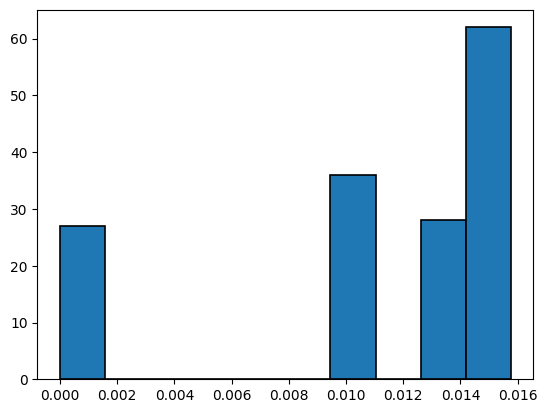

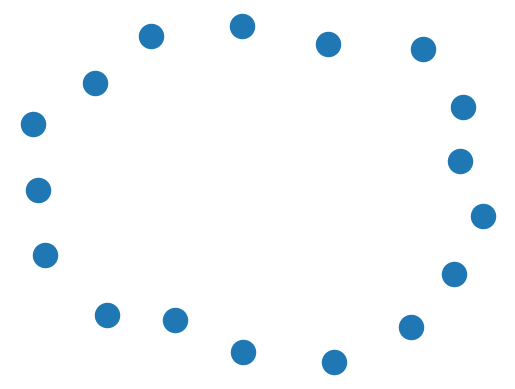

In [88]:
## Ellipse rotation test :: compute Euclidean distance matrix and select threshold
# Use the histogram to select the threshold.  Note that we want the un-squared matrix to select the threshold!
euc_matrix = Euclidean_Matrix(rot_images_vox,squared=False)
#print(euc_matrix)
fig,ax1 = plt.subplots()
plt.hist(euc_matrix[np.triu_indices(num_rotations)],edgecolor='black', linewidth=1.2)
eps = .025
# NOTE: if eps is too large, the graph will be disconnected and the distance matrix will have infs.
geo_distance,geo_graph = Geodesic_Matrix(rot_images_vox,eps,squared = True)
print('Graph weight matrix:')
# print(nx.adjacency_matrix(geo_graph).todense())
# print('Geodesic Distance Matrix:')
# print(geo_distance)
# print([n for n in geo_graph.neighbors(1)])
fig, ax2 = plt.subplots()
#nx.draw(geo_graph,ax=ax2,pos=nx.kamada_kawai_layout(geo_graph))
nx.draw(geo_graph,ax=ax2,pos=nx.spring_layout(geo_graph)) #########Problemm 

(1876, 2)
(1876, 2)
(1876, 2)
(1876, 2)
(1876, 2)
(1876, 2)
(1876, 2)
(1876, 2)
(1876, 2)
(1876, 2)
(1876, 2)
(1876, 2)
(1876, 2)
(1876, 2)
(1876, 2)
(1876, 2)


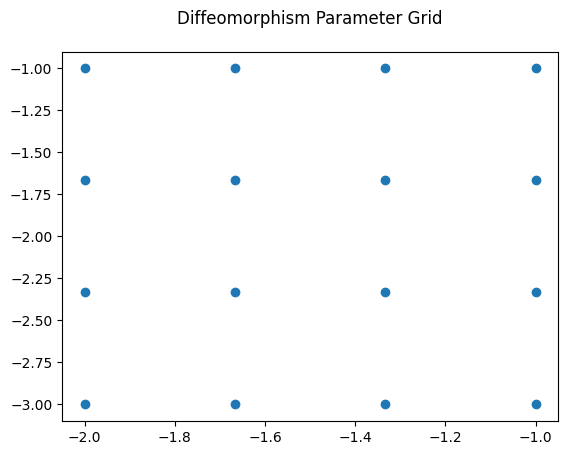

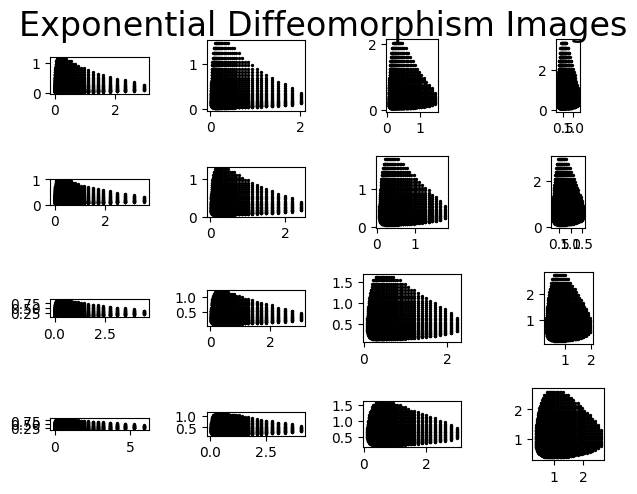

In [92]:
## Circle diffeomorphism test

# Generate circle
num_samplepoints = 50
radius = 1#0.1
circ = generate_circle([0,0],radius,samples=num_samplepoints)

# Generate diffeo set
num_diffeo = 4
x = np.linspace(-2,-1,num=num_diffeo)
y = np.linspace(-3,-1,num=num_diffeo)
xx,yy = np.meshgrid(x,y) #num_dilates x num_dilates matrices; each xx,yy entry is a dilation vector
xx = np.reshape(xx,(num_diffeo**2,1))
yy = np.reshape(yy,(num_diffeo**2,1))
diffeos = np.zeros((num_diffeo**2,2))
for i in range(len(xx)):
    diffeos[i,0] = xx[i]
    diffeos[i,1] = yy[i]

# Generate dilated images and image tensor
diff_images = np.zeros((circ.shape[0],circ.shape[1],num_diffeo**2))
#images[:,:,0] = circ
for i in range(num_diffeo**2):
    diff_images[:,:,i] = diffeo(circ,diffeos[i,0],diffeos[i,1])

fig,ax = plt.subplots()
ax.scatter(diffeos[:,0],diffeos[:,1])
ax.set_title("Diffeomorphism Parameter Grid",pad=20)
#plt.savefig('figures/DiffeoGrid.pdf')
plt.show()

fig2,dilate_axs = plt.subplots(num_diffeo,num_diffeo)
fig2.tight_layout()
for i in range(num_diffeo):
    for j in range(num_diffeo):
        idx = i+num_diffeo*j
        xxplt = diff_images[:,0,idx]
        yyplt = diff_images[:,1,idx]
        dilate_axs[i,j].scatter(xxplt,yyplt,s=2,c='#000000')
        dilate_axs[i,j].set_aspect('equal')
#         dilate_axs[i,j].set_xlim([-radius*diffeos[idx,0],radius*diffeos[idx,0]])
#         dilate_axs[i,j].set_ylim([-radius*diffeos[idx,1],radius*diffeos[idx,1]])
fig2.suptitle("Exponential Diffeomorphism Images",fontsize=24,y=1.02)
#plt.savefig('figures/DiffeoImages.pdf',bbox_inches='tight')
plt.show()

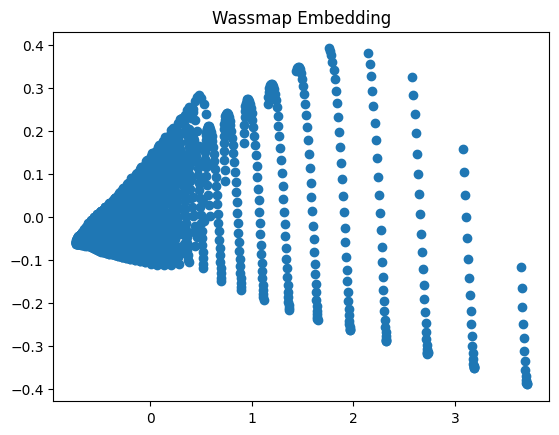

In [93]:
# Compute Wasserstein square distance matrix
squared = True
Wass_distance = Wasserstein_Matrix(diff_images,squared=squared)
# Compute and display Wassmap embedding
#WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
WassEmbedding = MDS(Wass_distance,squared=squared)
fig, ax = plt.subplots()
ax.scatter(WassEmbedding[:,0],WassEmbedding[:,1])
ax.set_title("Wassmap Embedding")
plt.show()

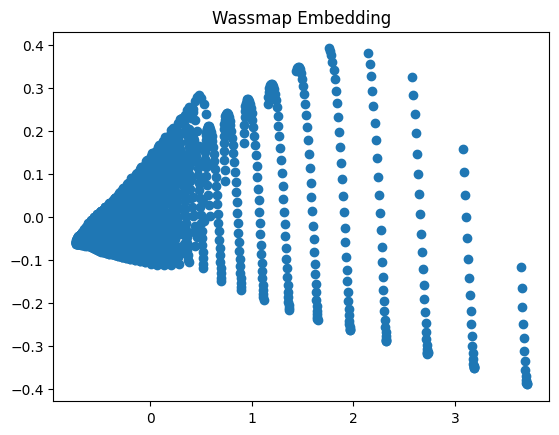

In [95]:
fig, ax = plt.subplots()
ax.scatter(WassEmbedding[:,0],WassEmbedding[:,1])
ax.set_title("Wassmap Embedding")
#plt.savefig('figures/DiffeoWassmapEmbedding.pdf')
plt.show()

In [112]:
nxg = 28
nyg = 28
x = np.linspace(0, 1, nxg)
y = np.linspace(0, 1, nyg)
xx, yy = np.meshgrid(x, y, indexing='ij')
grid = np.stack((xx,yy), axis=-1)  # This will create a grid with shape (28, 28, 2)

In [113]:
zeros_pointcloud = []
for i in range(zeros.shape[0]):
    zeros_pointcloud.append(vox_to_pointcloud(zeros[i,:,:], grid))

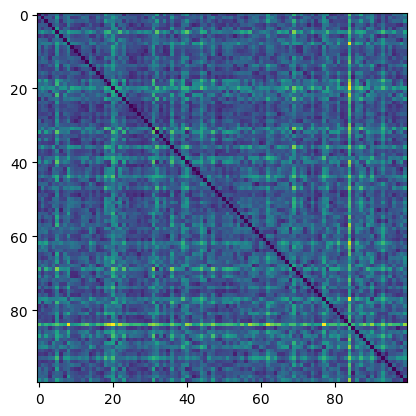

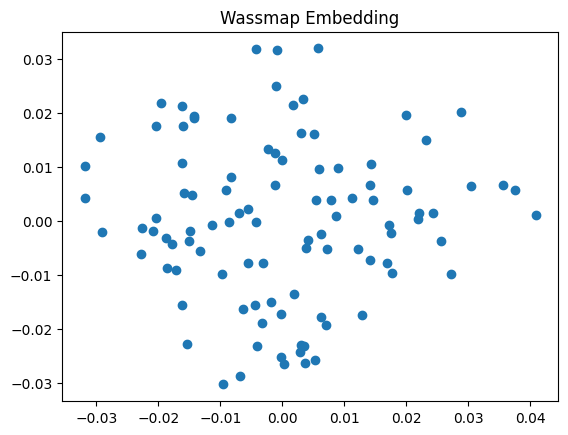

In [114]:
## MNIST test :: Compute Wasserstein square distance matrix
random_zeros = np.random.choice(range(len(zeros_pointcloud)),size=100,replace=False)

tic = time.perf_counter()
# Note the index trick for constructing the list of randomized zeros
Wass_distance = Wasserstein_Matrix([zeros_pointcloud[i] for i in random_zeros],squared=True)
toc = time.perf_counter() - tic
#print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance)
plt.show()

# Compute and display Wassmap embedding
#WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
WassEmbedding = MDS(Wass_distance,squared=True)
fig, ax = plt.subplots()
ax.scatter(WassEmbedding[:,0],WassEmbedding[:,1])
ax.set_title("Wassmap Embedding")
plt.show()

In [115]:
nxg = 28
nxy = 28
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))

## Need to have dynamic sizing for pointcloud tensor because output of vox_to_pointcloud is not consistent
#zeros_pointcloud = np.zeros(zeros.shape)
zeros_pointcloud = list()
for i in range(zeros.shape[0]):
    zeros_pointcloud.append(vox_to_pointcloud(zeros[i,:,:],grid))
# This creates a list of ndarrays, each element of which is a pointcloud representation of an MNIST 0
# zeros_pointcloud = np.asarray(zeros_pointcloud)
# zeros_pointcloud.shape
zeros_pointcloud[0].shape

(245, 3)

In [116]:
nxg = 28
nxy = 28
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))

## Need to have dynamic sizing for pointcloud tensor because output of vox_to_pointcloud is not consistent
zeros_pointcloud = np.zeros(zeros.shape)
ones_pointcloud = list()
for i in range(ones.shape[0]):
    ones_pointcloud.append(vox_to_pointcloud(ones[i,:,:],grid))
# This creates a list of ndarrays, each element of which is a pointcloud representation of an MNIST 0
zeros_pointcloud = np.asarray(zeros_pointcloud)
zeros_pointcloud.shape
ones_pointcloud[0].shape

(97, 3)

In [125]:
twos_pointcloud = list()
for i in range(twos.shape[0]):
    twos_pointcloud.append(vox_to_pointcloud(twos[i,:,:],grid))

In [126]:
fours_pointcloud = list()
for i in range(fours.shape[0]):
    fours_pointcloud.append(vox_to_pointcloud(fours[i,:,:],grid))

In [127]:
fives_pointcloud = list()
for i in range(fives.shape[0]):
    fives_pointcloud.append(vox_to_pointcloud(fives[i,:,:],grid))

In [128]:
sevens_pointcloud = list()
for i in range(sevens.shape[0]):
    sevens_pointcloud.append(vox_to_pointcloud(sevens[i,:,:],grid))

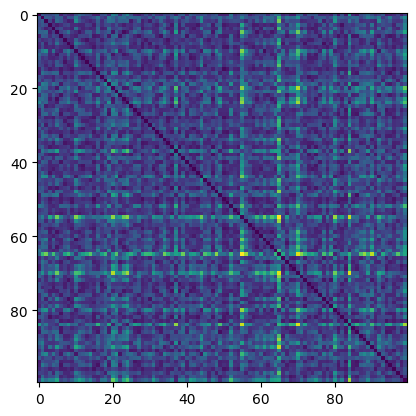

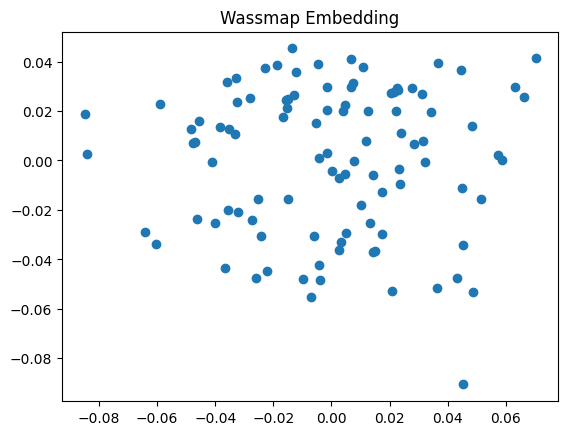

In [118]:
### MNIST test :: Compute Wasserstein square distance matrix
random_zeros = np.random.choice(range(len(zeros_pointcloud)),size=100,replace=False)

tic = time.perf_counter()
# Note the index trick for constructing the list of randomized zeros
Wass_distance = Wasserstein_Matrix([zeros_pointcloud[i] for i in random_zeros],squared=True)
toc = time.perf_counter() - tic
#print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance)
plt.show()

# Compute and display Wassmap embedding
#WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
WassEmbedding = MDS(Wass_distance,squared=True)
fig, ax = plt.subplots()
ax.scatter(WassEmbedding[:,0],WassEmbedding[:,1])
ax.set_title("Wassmap Embedding")
plt.show()

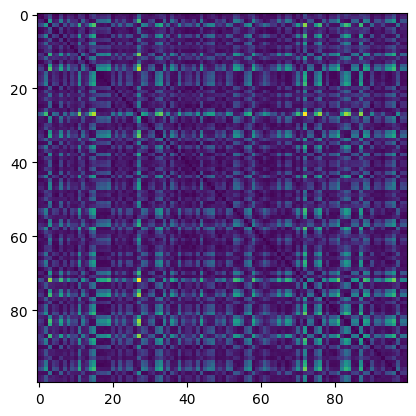

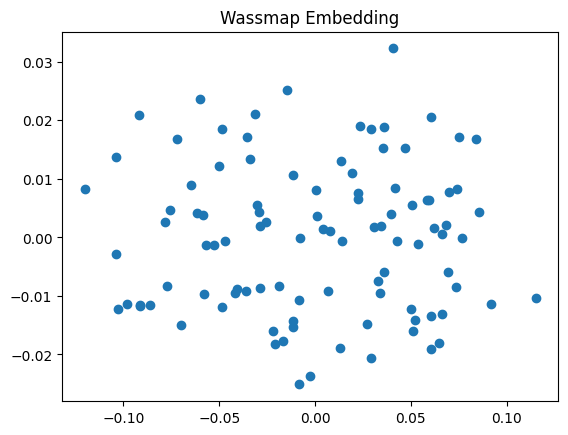

In [119]:
## MNIST test :: Compute Wasserstein square distance matrix
random_ones = np.random.choice(range(len(ones_pointcloud)),size=100,replace=False)

tic = time.perf_counter()
# Note the index trick for constructing the list of randomized zeros
Wass_distance = Wasserstein_Matrix([ones_pointcloud[i] for i in random_ones],squared=True)
toc = time.perf_counter() - tic
#print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance)
plt.show()

# Compute and display Wassmap embedding
#WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
WassEmbedding = MDS(Wass_distance,squared=True)
fig, ax = plt.subplots()
ax.scatter(WassEmbedding[:,0],WassEmbedding[:,1])
ax.set_title("Wassmap Embedding")
plt.show()

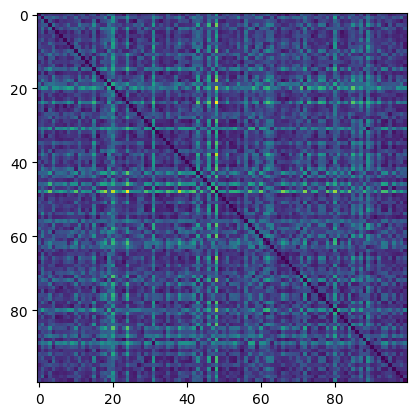

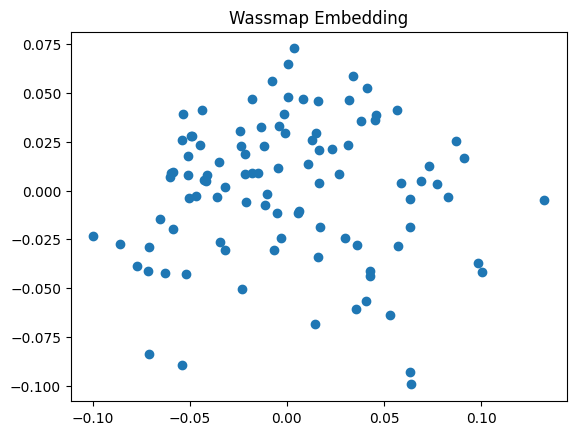

In [129]:
## MNIST test :: Compute Wasserstein square distance matrix
random_twos = np.random.choice(range(len(twos_pointcloud)),size=100,replace=False)

tic = time.perf_counter()
# Note the index trick for constructing the list of randomized zeros
Wass_distance = Wasserstein_Matrix([twos_pointcloud[i] for i in random_twos],squared=True)
toc = time.perf_counter() - tic
#print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance)
plt.show()

# Compute and display Wassmap embedding
#WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
WassEmbedding = MDS(Wass_distance,squared=True)
fig, ax = plt.subplots()
ax.scatter(WassEmbedding[:,0],WassEmbedding[:,1])
ax.set_title("Wassmap Embedding")
plt.show()

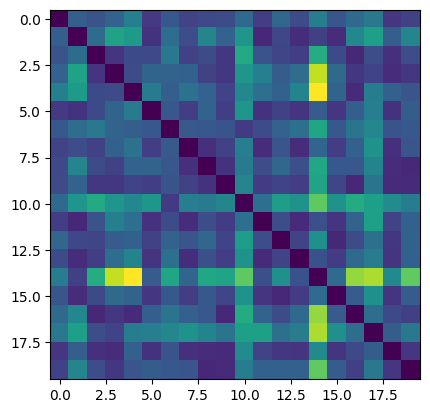

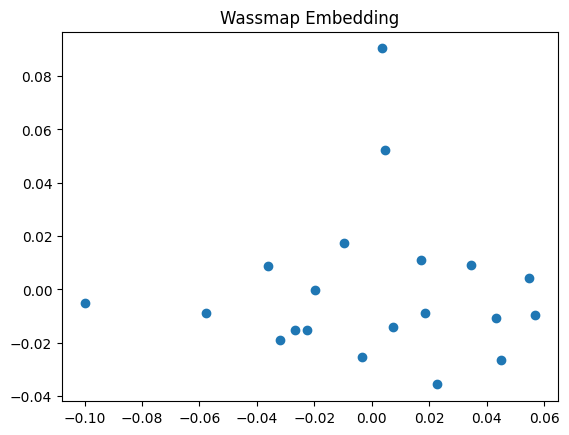

In [130]:
## MNIST test :: Compute Wasserstein square distance matrix
random_fours = np.random.choice(range(len(fours_pointcloud)),size=20,replace=False)

tic = time.perf_counter()
# Note the index trick for constructing the list of randomized zeros
Wass_distance = Wasserstein_Matrix([fours_pointcloud[i] for i in random_fours],squared=True)
toc = time.perf_counter() - tic
#print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance)
plt.show()

# Compute and display Wassmap embedding
#WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
WassEmbedding = MDS(Wass_distance,squared=True)
fig, ax = plt.subplots()
ax.scatter(WassEmbedding[:,0],WassEmbedding[:,1])
ax.set_title("Wassmap Embedding")
plt.show()

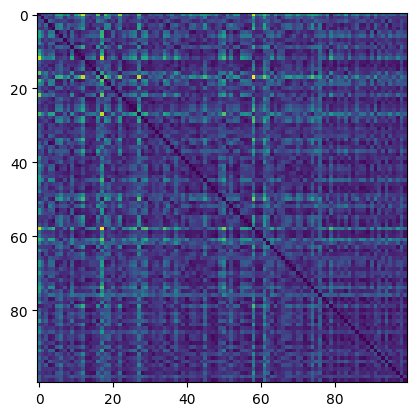

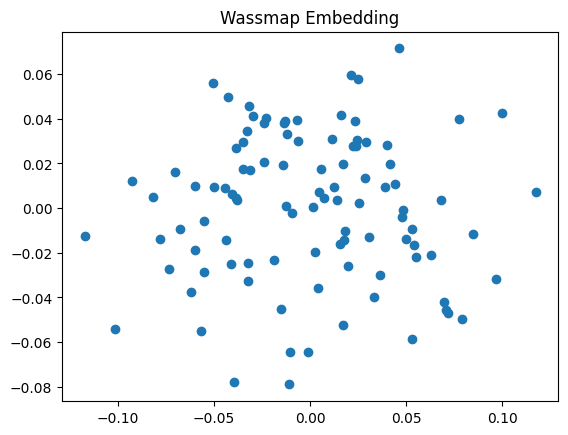

In [131]:
## MNIST test :: Compute Wasserstein square distance matrix
random_sevens = np.random.choice(range(len(sevens_pointcloud)),size=100,replace=False)

tic = time.perf_counter()
# Note the index trick for constructing the list of randomized zeros
Wass_distance = Wasserstein_Matrix([sevens_pointcloud[i] for i in random_sevens],squared=True)
toc = time.perf_counter() - tic
#print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance)
plt.show()

# Compute and display Wassmap embedding
#WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
WassEmbedding = MDS(Wass_distance,squared=True)
fig, ax = plt.subplots()
ax.scatter(WassEmbedding[:,0],WassEmbedding[:,1])
ax.set_title("Wassmap Embedding")
plt.show()

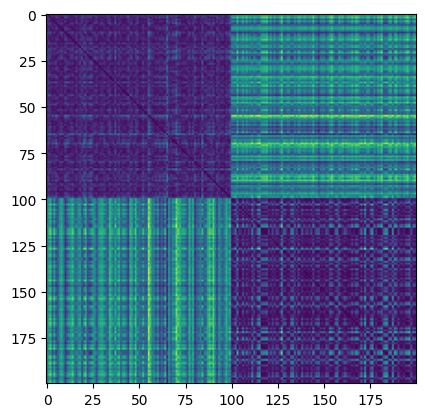

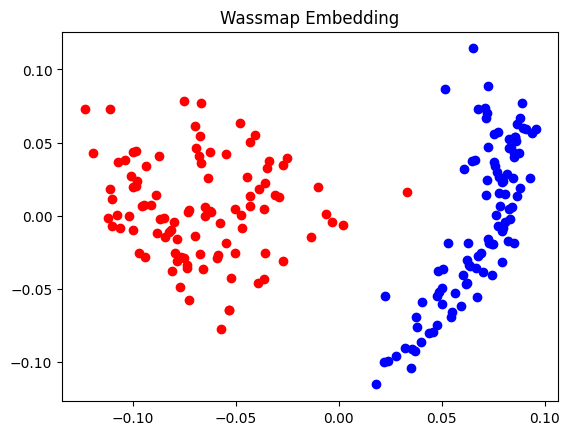

In [132]:
tic = time.perf_counter()
# Note the index trick for constructing the list of randomized zeros
dist = []
label=[]

for i in random_zeros:
  dist.append(zeros_pointcloud[i])
for i in random_ones:
  dist.append(ones_pointcloud[i])
# for i in random_twos:
#   dist.append(twos_pointcloud[i])
# for i in random_fours:
#   dist.append(fours_pointcloud[i])
Wass_distance = Wasserstein_Matrix(dist,squared=True)
toc = time.perf_counter() - tic
#print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance)
plt.show()

# Compute and display Wassmap embedding
#WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
WassEmbedding = MDS(Wass_distance,squared=True)
fig, ax = plt.subplots()
num_zeros = len(random_zeros)
num_ones = len(random_ones)
#num_twos = len(random_twos)
ax.scatter(WassEmbedding[range(num_zeros),0],WassEmbedding[range(num_zeros),1],c='r')
ax.scatter(WassEmbedding[range(num_zeros,num_zeros+num_ones),0],WassEmbedding[range(num_zeros,num_zeros+num_ones),1],c='b')
#ax.scatter(WassEmbedding[range(num_zeros+num_ones,num_zeros+num_ones+num_twos),0],WassEmbedding[range(num_zeros+num_ones,num_zeros+num_ones+num_twos),1],c='k')
# ax.scatter(WassEmbedding[range(len(random_ones)),0],WassEmbedding[range(len(random_ones)),1],c='r')
# ax.scatter(WassEmbedding[range(len(random_ones),len(random_ones)+len(random_zeros)),0],WassEmbedding[range(len(random_ones),len(random_ones)+len(random_zeros)),1],c='b')
ax.set_title("Wassmap Embedding")
#plt.savefig('/content/drive/My Drive/Colab Notebooks/figures/WassmapMNIST01.pdf',bbox_inches='tight')
plt.show()

(200, 2)


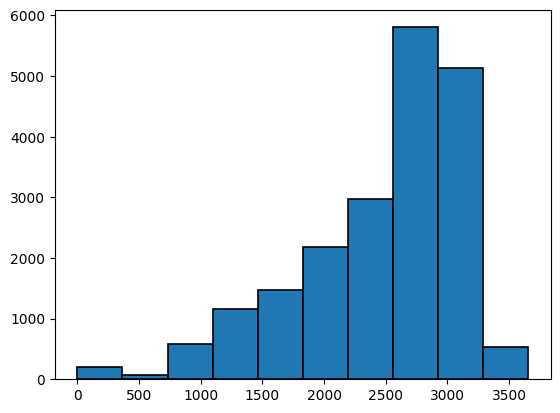

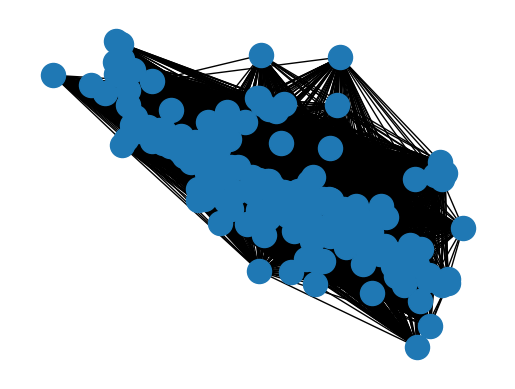

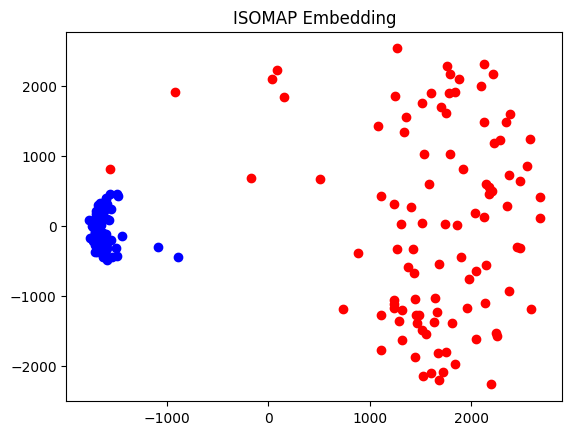

In [133]:
# tic = time.perf_counter()
# # Note the index trick for constructing the list of randomized zeros
# dist = []
# label=[]

# for i in random_zeros:
#   dist.append(zeros_pointcloud[i])
# for i in random_ones:
#   dist.append(ones_pointcloud[i])
# # for i in random_twos:
# #   dist.append(twos_pointcloud[i])
# for i in random_fours:
#   dist.append(fours_pointcloud[i])
# Wass_distance = Wasserstein_Matrix(dist,squared=True)
# toc = time.perf_counter() - tic
# #print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
# fig,ax = plt.subplots()
# ax.imshow(Wass_distance)
# plt.show()
zeros_test = zeros[random_zeros,:,:]
ones_test = ones[random_ones,:,:]
joint = np.concatenate((zeros_test,ones_test)).T

## Ellipse rotation test :: compute Euclidean distance matrix and select threshold
# Use the histogram to select the threshold.  Note that we want the un-squared matrix to select the threshold!
euc_matrix = Euclidean_Matrix(joint,squared=False)
#print(euc_matrix)
fig,ax1 = plt.subplots()
plt.hist(euc_matrix[np.triu_indices(200)],edgecolor='black', linewidth=1.2)
eps = 2500
# NOTE: if eps is too large, the graph will be disconnected and the distance matrix will have infs.
geo_distance,geo_graph = Geodesic_Matrix(joint,eps,squared = True)
# print('Graph weight matrix:')
# print(nx.adjacency_matrix(geo_graph).todense())
# print('Geodesic Distance Matrix:')
# print(geo_distance)
# print([n for n in geo_graph.neighbors(1)])
fig, ax2 = plt.subplots()
#nx.draw(geo_graph,ax=ax2,pos=nx.kamada_kawai_layout(geo_graph))
nx.draw(geo_graph,ax=ax2,pos=nx.spring_layout(geo_graph))

num_zeros = 100
num_ones = 100

# Compute the geodesic distance matrix
EucEmbedding = MDS(geo_distance,squared=True)
#EucEmbedding = MDS(euc_matrix,squared=True)
print(EucEmbedding.shape)
fig, ax3 = plt.subplots()
ax3.scatter(EucEmbedding[range(num_zeros),0], EucEmbedding[range(num_zeros),1],c='r')
ax3.scatter(EucEmbedding[range(num_zeros,num_zeros+num_ones),0], EucEmbedding[range(num_zeros,num_zeros+num_ones),1],c='b')
# ax.scatter(WassEmbedding[range(num_zeros,num_zeros+num_ones),0],WassEmbedding[range(num_zeros,num_zeros+num_ones),1],c='r')
# ax.scatter(WassEmbedding[range(num_zeros,num_zeros+num_ones),0],WassEmbedding[range(num_zeros,num_zeros+num_ones),1],c='b')
ax3.set_title("ISOMAP Embedding")
#ax3.tick_params(labelsize=12)
#plt.savefig('/content/drive/My Drive/Colab Notebooks/figures/ISOMAPMNIST01_eps2500.pdf',bbox_inches='tight')
plt.show()

# # Compute and display Wassmap embedding
# #WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
# EucEmbedding = MDS(Wass_distance,squared=True)
# fig, ax = plt.subplots()
# num_zeros = len(random_zeros)
# num_ones = len(random_ones)
# num_twos = len(random_twos)
# ax.scatter(WassEmbedding[range(num_zeros),0],WassEmbedding[range(num_zeros),1],c='r')
# ax.scatter(WassEmbedding[range(num_zeros,num_zeros+num_ones),0],WassEmbedding[range(num_zeros,num_zeros+num_ones),1],c='b')
# #ax.scatter(WassEmbedding[range(num_zeros+num_ones,num_zeros+num_ones+num_twos),0],WassEmbedding[range(num_zeros+num_ones,num_zeros+num_ones+num_twos),1],c='k')
# # ax.scatter(WassEmbedding[range(len(random_ones)),0],WassEmbedding[range(len(random_ones)),1],c='r')
# # ax.scatter(WassEmbedding[range(len(random_ones),len(random_ones)+len(random_zeros)),0],WassEmbedding[range(len(random_ones),len(random_ones)+len(random_zeros)),1],c='b')
# ax.set_title("Wassmap Embedding")
# plt.show()

(200, 2)


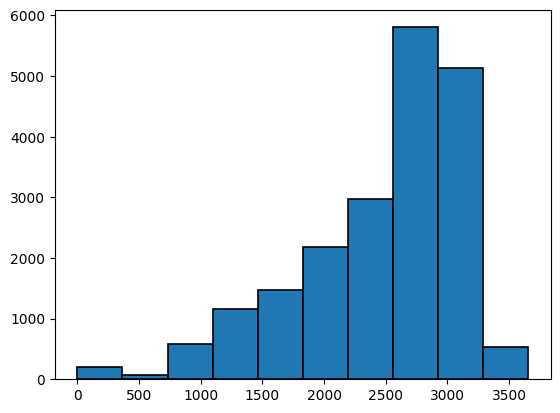

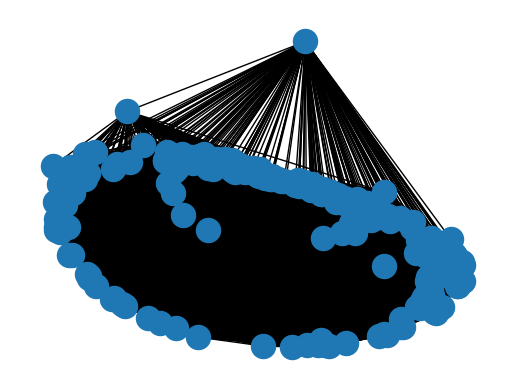

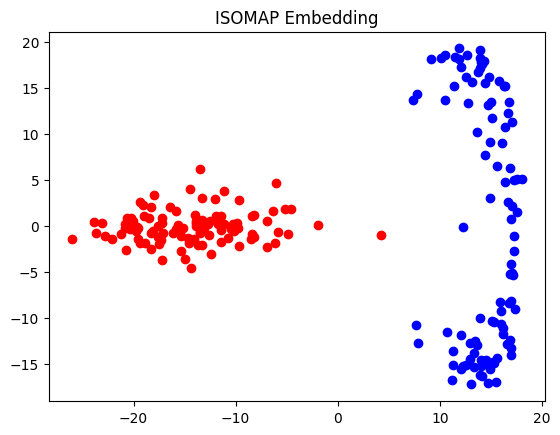

In [134]:
# tic = time.perf_counter()
# # Note the index trick for constructing the list of randomized zeros
# dist = []
# label=[]

# for i in random_zeros:
#   dist.append(zeros_pointcloud[i])
# for i in random_ones:
#   dist.append(ones_pointcloud[i])
# # for i in random_twos:
# #   dist.append(twos_pointcloud[i])
# for i in random_fours:
#   dist.append(fours_pointcloud[i])
# Wass_distance = Wasserstein_Matrix(dist,squared=True)
# toc = time.perf_counter() - tic
# #print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
# fig,ax = plt.subplots()
# ax.imshow(Wass_distance)
# plt.show()
zeros_test = zeros[random_zeros,:,:]
ones_test = ones[random_ones,:,:]
joint = np.concatenate((zeros_test,ones_test)).T

## Ellipse rotation test :: compute Euclidean distance matrix and select threshold
# Use the histogram to select the threshold.  Note that we want the un-squared matrix to select the threshold!
euc_matrix = Euclidean_Matrix(joint,squared=False)
#print(euc_matrix)
fig,ax1 = plt.subplots()
plt.hist(euc_matrix[np.triu_indices(200)],edgecolor='black', linewidth=1.2)
eps = 1000
# NOTE: if eps is too large, the graph will be disconnected and the distance matrix will have infs.
geo_distance,geo_graph = Geodesic_Matrix(joint,eps,squared = True)
# print('Graph weight matrix:')
# print(nx.adjacency_matrix(geo_graph).todense())
# print('Geodesic Distance Matrix:')
# print(geo_distance)
# print([n for n in geo_graph.neighbors(1)])
fig, ax2 = plt.subplots()
#nx.draw(geo_graph,ax=ax2,pos=nx.kamada_kawai_layout(geo_graph))
nx.draw(geo_graph,ax=ax2,pos=nx.spring_layout(geo_graph))

num_zeros = 100
num_ones = 100

# Compute the geodesic distance matrix
#EucEmbedding = MDS(geo_distance,squared=True)
EucEmbedding = MDS(euc_matrix,squared=True)
print(EucEmbedding.shape)
fig, ax3 = plt.subplots()
ax3.scatter(EucEmbedding[range(num_zeros),0], EucEmbedding[range(num_zeros),1],c='r')
ax3.scatter(EucEmbedding[range(num_zeros,num_zeros+num_ones),0], EucEmbedding[range(num_zeros,num_zeros+num_ones),1],c='b')
# ax.scatter(WassEmbedding[range(num_zeros,num_zeros+num_ones),0],WassEmbedding[range(num_zeros,num_zeros+num_ones),1],c='r')
# ax.scatter(WassEmbedding[range(num_zeros,num_zeros+num_ones),0],WassEmbedding[range(num_zeros,num_zeros+num_ones),1],c='b')
ax3.set_title("ISOMAP Embedding")
#ax3.tick_params(labelsize=12)
#plt.savefig('/content/drive/My Drive/Colab Notebooks/figures/RotationNoncenteredISOMAPEmbedding.pdf',bbox_inches='tight')
plt.show()

# # Compute and display Wassmap embedding
# #WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
# EucEmbedding = MDS(Wass_distance,squared=True)
# fig, ax = plt.subplots()
# num_zeros = len(random_zeros)
# num_ones = len(random_ones)
# num_twos = len(random_twos)
# ax.scatter(WassEmbedding[range(num_zeros),0],WassEmbedding[range(num_zeros),1],c='r')
# ax.scatter(WassEmbedding[range(num_zeros,num_zeros+num_ones),0],WassEmbedding[range(num_zeros,num_zeros+num_ones),1],c='b')
# #ax.scatter(WassEmbedding[range(num_zeros+num_ones,num_zeros+num_ones+num_twos),0],WassEmbedding[range(num_zeros+num_ones,num_zeros+num_ones+num_twos),1],c='k')
# # ax.scatter(WassEmbedding[range(len(random_ones)),0],WassEmbedding[range(len(random_ones)),1],c='r')
# # ax.scatter(WassEmbedding[range(len(random_ones),len(random_ones)+len(random_zeros)),0],WassEmbedding[range(len(random_ones),len(random_ones)+len(random_zeros)),1],c='b')
# ax.set_title("Wassmap Embedding")
# plt.show()

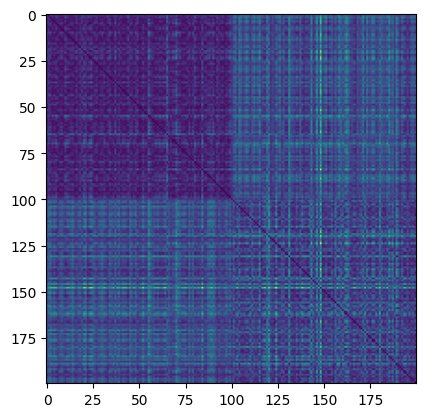

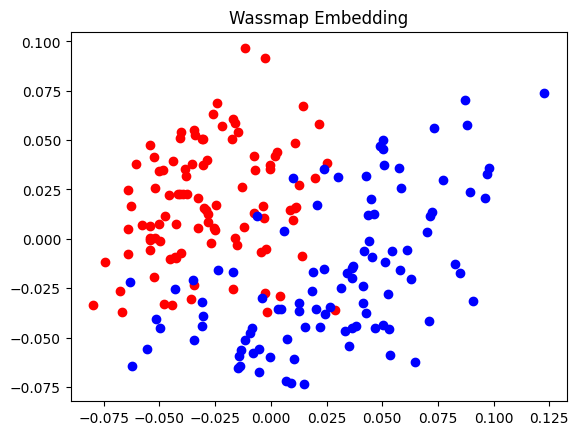

In [135]:
tic = time.perf_counter()
# Note the index trick for constructing the list of randomized zeros
dist = []
label=[]

for i in random_zeros:
  dist.append(zeros_pointcloud[i])
# for i in random_ones:
#   dist.append(ones_pointcloud[i])
for i in random_twos:
  dist.append(twos_pointcloud[i])
# for i in random_fours:
#   dist.append(fours_pointcloud[i])
Wass_distance = Wasserstein_Matrix(dist,squared=True)
toc = time.perf_counter() - tic
#print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance)
plt.show()

# Compute and display Wassmap embedding
#WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
WassEmbedding = MDS(Wass_distance,squared=True)
fig, ax = plt.subplots()
num_zeros = len(random_zeros)
num_ones = len(random_ones)
num_twos = len(random_twos)
ax.scatter(WassEmbedding[range(num_zeros),0],WassEmbedding[range(num_zeros),1],c='r')
ax.scatter(WassEmbedding[range(num_zeros,num_zeros+num_ones),0],WassEmbedding[range(num_zeros,num_zeros+num_ones),1],c='b')
#ax.scatter(WassEmbedding[range(num_zeros+num_ones,num_zeros+num_ones+num_twos),0],WassEmbedding[range(num_zeros+num_ones,num_zeros+num_ones+num_twos),1],c='k')
# ax.scatter(WassEmbedding[range(len(random_ones)),0],WassEmbedding[range(len(random_ones)),1],c='r')
# ax.scatter(WassEmbedding[range(len(random_ones),len(random_ones)+len(random_zeros)),0],WassEmbedding[range(len(random_ones),len(random_ones)+len(random_zeros)),1],c='b')
ax.set_title("Wassmap Embedding")
plt.show()

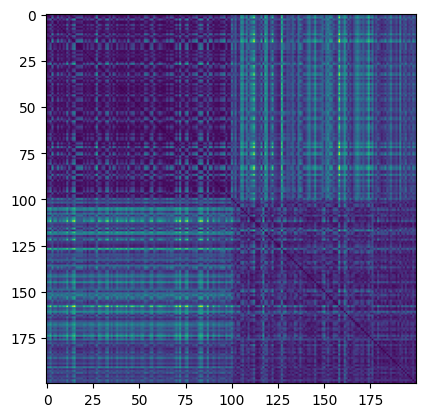

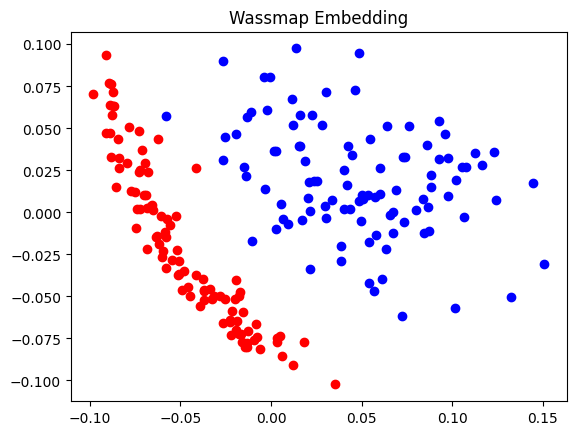

In [136]:
tic = time.perf_counter()
# Note the index trick for constructing the list of randomized zeros
dist = []
label=[]

# for i in random_zeros:
#   dist.append(zeros_pointcloud[i])
for i in random_ones:
  dist.append(ones_pointcloud[i])
# for i in random_twos:
#   dist.append(twos_pointcloud[i])
# for i in random_fours:
#   dist.append(fours_pointcloud[i])
for i in random_sevens:
  dist.append(sevens_pointcloud[i])
Wass_distance = Wasserstein_Matrix(dist,squared=True)
toc = time.perf_counter() - tic
#print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance)
plt.show()

# Compute and display Wassmap embedding
#WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
WassEmbedding = MDS(Wass_distance,squared=True)
fig, ax = plt.subplots()
num_zeros = len(random_zeros)
num_ones = len(random_ones)
num_twos = len(random_twos)
ax.scatter(WassEmbedding[range(num_zeros),0],WassEmbedding[range(num_zeros),1],c='r')
ax.scatter(WassEmbedding[range(num_zeros,num_zeros+num_ones),0],WassEmbedding[range(num_zeros,num_zeros+num_ones),1],c='b')
#ax.scatter(WassEmbedding[range(num_zeros+num_ones,num_zeros+num_ones+num_twos),0],WassEmbedding[range(num_zeros+num_ones,num_zeros+num_ones+num_twos),1],c='k')
# ax.scatter(WassEmbedding[range(len(random_ones)),0],WassEmbedding[range(len(random_ones)),1],c='r')
# ax.scatter(WassEmbedding[range(len(random_ones),len(random_ones)+len(random_zeros)),0],WassEmbedding[range(len(random_ones),len(random_ones)+len(random_zeros)),1],c='b')
ax.set_title("Wassmap Embedding")
plt.show()

/var/folders/2x/m3nyg7x50mzg_7wsnzcm7hxr0000gn/T/ipykernel_52911/1784630450.py:7: RuntimeWarning: invalid value encountered in divide
  Uwts = Uwts/np.sum(Uwts)
/var/folders/2x/m3nyg7x50mzg_7wsnzcm7hxr0000gn/T/ipykernel_52911/1784630450.py:8: RuntimeWarning: invalid value encountered in divide
  Vwts = Vwts/np.sum(Vwts)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/ot/lp/__init__.py:571: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


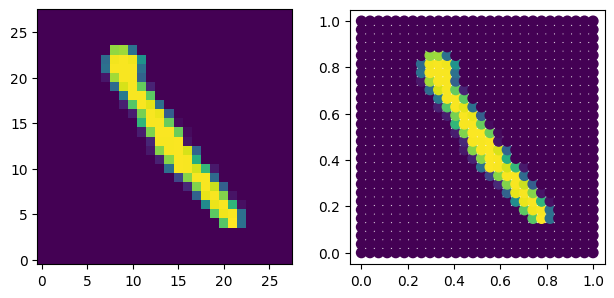

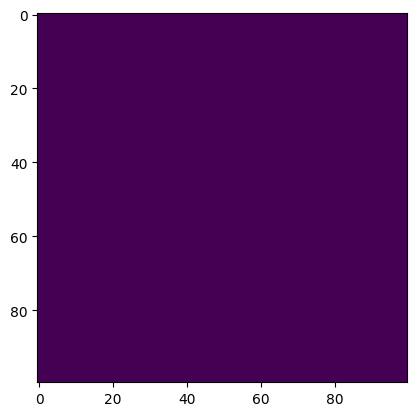

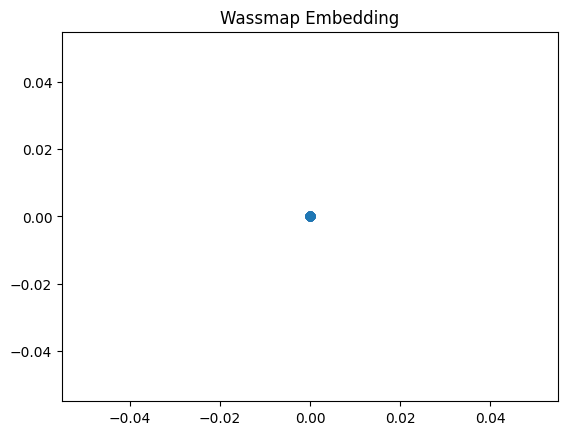

In [138]:
## Create pointcloud tensor from MNIST one images
nxg = 28
nxy = 28
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))

## Need to have dynamic sizing for pointcloud tensor because output of vox_to_pointcloud is not consistent
#zeros_pointcloud = np.zeros(zeros.shape)
ones_pointcloud = list()
for i in range(ones.shape[0]):
    ones_pointcloud.append(vox_to_pointcloud(ones[i,:,:],grid,eps=-1))
# This creates a list of ndarrays, each element of which is a pointcloud representation of an MNIST 0
ones_pointcloud = np.asarray(ones_pointcloud)
ones_pointcloud.shape

fig1,(ax1,ax2) = plt.subplots(1,2)
fig1.tight_layout()
ax1.imshow(ones[0,:,:],origin='lower')
ax2.scatter(ones_pointcloud[0,:,0],ones_pointcloud[0,:,1],s=50,c=ones_pointcloud[0,:,2])

ax2.set_aspect(1)

## MNIST test :: Compute Wasserstein square distance matrix
random_ones = np.random.choice(range(ones_pointcloud.shape[0]),size=100,replace=False)
tic = time.perf_counter()
Wass_distance = Wasserstein_Matrix(ones[random_ones,:,:],squared=True)
toc = time.perf_counter() - tic
#print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance)
plt.show()


# Compute and display Wassmap embedding
#WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
WassEmbedding = MDS(Wass_distance,squared=True)
fig, ax = plt.subplots()
ax.scatter(WassEmbedding[:,0],WassEmbedding[:,1])
ax.set_title("Wassmap Embedding")
plt.show()

/var/folders/2x/m3nyg7x50mzg_7wsnzcm7hxr0000gn/T/ipykernel_52911/1784630450.py:7: RuntimeWarning: invalid value encountered in divide
  Uwts = Uwts/np.sum(Uwts)
/var/folders/2x/m3nyg7x50mzg_7wsnzcm7hxr0000gn/T/ipykernel_52911/1784630450.py:8: RuntimeWarning: invalid value encountered in divide
  Vwts = Vwts/np.sum(Vwts)


AssertionError: 
Arrays are not almost equal to 6 decimals
a and b vector must have the same sum
x and y nan location mismatch:
 x: array(nan)
 y: array([1.])

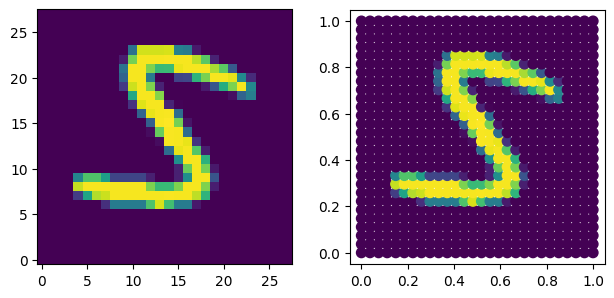

In [139]:
## Create pointcloud tensor from MNIST two images
nxg = 28
nxy = 28
x = np.linspace(0,1,nxg)
y = np.linspace(0,1,nyg)
xx,yy = np.meshgrid(x,y,indexing='ij')
grid = np.stack((xx,yy))

## Need to have dynamic sizing for pointcloud tensor because output of vox_to_pointcloud is not consistent
#zeros_pointcloud = np.zeros(zeros.shape)
twos_pointcloud = list()
for i in range(twos.shape[0]):
    twos_pointcloud.append(vox_to_pointcloud(twos[i,:,:],grid,eps=-1))
# This creates a list of ndarrays, each element of which is a pointcloud representation of an MNIST 0
twos_pointcloud = np.asarray(twos_pointcloud)
twos_pointcloud.shape

fig1,(ax1,ax2) = plt.subplots(1,2)
fig1.tight_layout()
ax1.imshow(twos[2,:,:],origin='lower')
ax2.scatter(twos_pointcloud[2,:,0],twos_pointcloud[2,:,1],s=50,c=twos_pointcloud[2,:,2])

ax2.set_aspect(1)

## MNIST test :: Compute Wasserstein square distance matrix
random_twos = np.random.choice(range(twos_pointcloud.shape[0]),size=100,replace=False)
tic = time.perf_counter()
Wass_distance = Wasserstein_Matrix(twos[random_twos,:,:],squared=True)
toc = time.perf_counter() - tic
#print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))
fig,ax = plt.subplots()
ax.imshow(Wass_distance)
plt.show()


# Compute and display Wassmap embedding
#WassEmbedding = man.MDS(n_components=2,metric=True,dissimilarity='precomputed',eps=1e-4).fit_transform(Wass_distance)
WassEmbedding = MDS(Wass_distance,squared=True)
fig, ax = plt.subplots()
ax.scatter(WassEmbedding[:,0],WassEmbedding[:,1])
ax.set_title("Wassmap Embedding")
plt.show()